# Reproduction of Casile et al. (2019) "Contrast sensitivity reveals an oculomotor strategy for temporally encoding space"

The purpose of this notebook is to recreate and visualize the retinal input and the (spatial and temporal) kernels as described in Casile et al. (2019) "Contrast sensitivity reveals an oculomotor strategy for temporally encoding space"..



_Created on 30.06.2020_

_Last update on 04.05.2021_

_(c) Lynn Schmittwilken, Nicolas Roth, Maher Shei, Florian Blume, Maximilian Pohlmann_

Hint: Due to the interactive components not working without the data in working memory, we recommend to "Restart & Run All".

In [1]:
import numpy as np
from scipy.signal import filtfilt
import matplotlib.pyplot as plt
import matplotlib.animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import ScalarFormatter
from numpy.fft import fft, ifft, fftn, ifftn, fftshift, ifftshift, fftfreq
from IPython.display import Video
from ipywidgets import interact, interact_manual, IntSlider, FloatSlider

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
SMALL_SIZE = 15
MEDIUM_SIZE = 17
BIGGER_SIZE = 22
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
def add_colorbar(ax, im):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

# Retinal input

### Parameters

The following parameters determine the spatial and temporal dimensions of the retinal input and relate the discrete units of pixels and frames to the "empirical units" of degrees of visual angle and seconds respectively, by assuming viewing distance and framerate. Thus, the consistency and compatibility between the input and the kernels (which are based on measurements of Ganglion cells) is ensured.

In [3]:
n_size = 240 # width and height in pixels
px_per_deg = 60 # pixels per degree of visual angle
deg_per_px = 1/px_per_deg

n_time = 320 # number of frames
fps = 100 # frames per second 
dt = 1/fps # duration of a frame in seconds
time = np.arange(0, n_time*dt, dt) # vector of timestamps (in seconds) for each frame

### Create the retinal input

The following functions are used to create the retinal input.

`create_grating` creates a 2-dimensional grating of a chosen size, spatial frequency, orientation and phase.

`add_temporal_modulation` creates a 3-dimensional array in which the above 2D grating is modulated over time. The temporal modulation consists of a sinusoidal flicker of a chosen frequency `omega_t`.

`add_ramping` adds a sigmoidal ramping function that fades the grating in and out at the beginning and end of the temporal modulation period, respectively. 

To simplify the problem, eye movements are set to zero, equivalent to $\xi(t)=0 \, \forall t$ in Eq. 1.

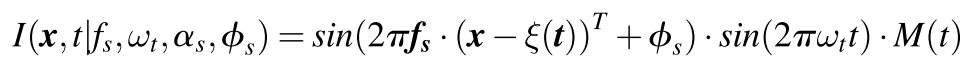


`add_spatial_gaussian` turns the sinusioid grating into a Gabor patch by multiplying it with a Gaussian kernel. This is not explicitly described in the paper, but we wanted to just try it out.

In [4]:
def create_grating(f_s, alpha_s, phi_s):
    """
    Creates 2d-grating as stimulus which is input to the filters.
    parameters
    -----------
    f_s - spatial frequency of the grating [c/d]
    alpha_s - orientation of the grating [rad]
    phi_s - phase of the grating [rad]
    """
    # Create sinusoid
    amp = 1.
    _f_s = f_s * n_size * deg_per_px # convert from c/d to total cycles (cycles along n_size)
    a = np.linspace(-1*_f_s, 1*_f_s, n_size) # spatial frequency and stimulus size
    
    _f_s = [np.cos(alpha_s), np.sin(alpha_s)]
    [x, y] = np.meshgrid(a, a)
    grating = amp * np.sin(_f_s[0] * np.pi * x  + _f_s[1] * np.pi * y + phi_s)
    return grating

def add_spatial_gaussian(grating, sigma):
    """
    Turns the sinusioid grating into a Gabor patch by multiplying it with a Gaussian kernel.
    parameters
    -----------
    grating - 2D grating from create_grating-func
    sigma - of Gaussian
    """
    x, y = np.meshgrid(np.linspace(-1, 1, n_size), np.linspace(-1, 1, n_size))
    r = np.sqrt(x**2 + y**2)
    g = np.exp(-(r**2 / (2.0 * sigma**2)))
    
    return grating * g


def add_temporal_modulation(grating, omega_t):
    """
    Add temporal modulation of grating.
    parameters
    -----------
    grating - 2D grating from create_grating-func
    omega_t - frequency of sinusoidal modulation of grating over time [Hz]
    """
    _grating_video = np.repeat(np.expand_dims(grating, -1), n_time, 2)
    
    temp_modul = np.sin(2 * np.pi * omega_t * time) # sinus going from -1 to 1
    #temp_modul = (temp_modul-temp_modul.min())/(temp_modul.max()-temp_modul.min()) # scale to [0,1]  
    
    return _grating_video * temp_modul


def add_ramping(grating_video, ramp_time):
    """
    Add ramping in and fading out (implemented as sigmoid function).
    parameters
    ------------
    grating_video - 2D grating modulated in time from create_grating, add_temporal_modulation
    ramp_time - duration [s] of ramp-up and ramp-down
    """
    ramp_frames = int(ramp_time * fps)
    
    ramp_up = 1/(1+np.exp(-(time[:ramp_frames]*20-9)))
    ramp_down = 1 - ramp_up   
    
    modulation = np.ones([n_time])
    modulation[:ramp_frames] = ramp_up
    modulation[-ramp_frames:] = ramp_down
    
    return grating_video * modulation

### Example grating video

In [5]:
f_s = 3.
alpha_s = np.pi/6
phi_s = 0
gabor_sigma=0.25
omega_t = 6.
ramp_time = 1.

grating = create_grating(f_s, alpha_s, phi_s)
#grating = add_spatial_gaussian(grating, gabor_sigma)
grating_video = add_temporal_modulation(grating, omega_t)
grating_video = add_ramping(grating_video, ramp_time)

In [6]:
def save_video(video, fname='grating_video', figsize=(6, 6)):
    """
    Save 3D arrays as grayscale MP4 videos, using matplotlib.animate.
    parameters
    ------------
    video - 3D array, where the last dimension is the time dimension
    fname - file basename (without type ending)
    figsize - of underlying matplotlib figure
    """
    fig = plt.figure(figsize=figsize)
    im = plt.imshow(video[:, :, 0], cmap='gray', vmin=video.min(), vmax=video.max());
    plt.title('Frame 000')

    def animate(i):
        im.set_array(video[:, :, i])
        plt.title(f'Frame {i:03d}')

    anim = matplotlib.animation.FuncAnimation(fig, animate, frames = n_time, interval = int(dt*1000))
    anim.save('grating_videos/%s.mp4' % fname, fps=fps, extra_args=['-vcodec', 'libx264'])
    plt.close()

In [7]:
#save_video(grating_video)

In [8]:
Video('grating_videos/grating_video.mp4')

### Visualizing individual frames

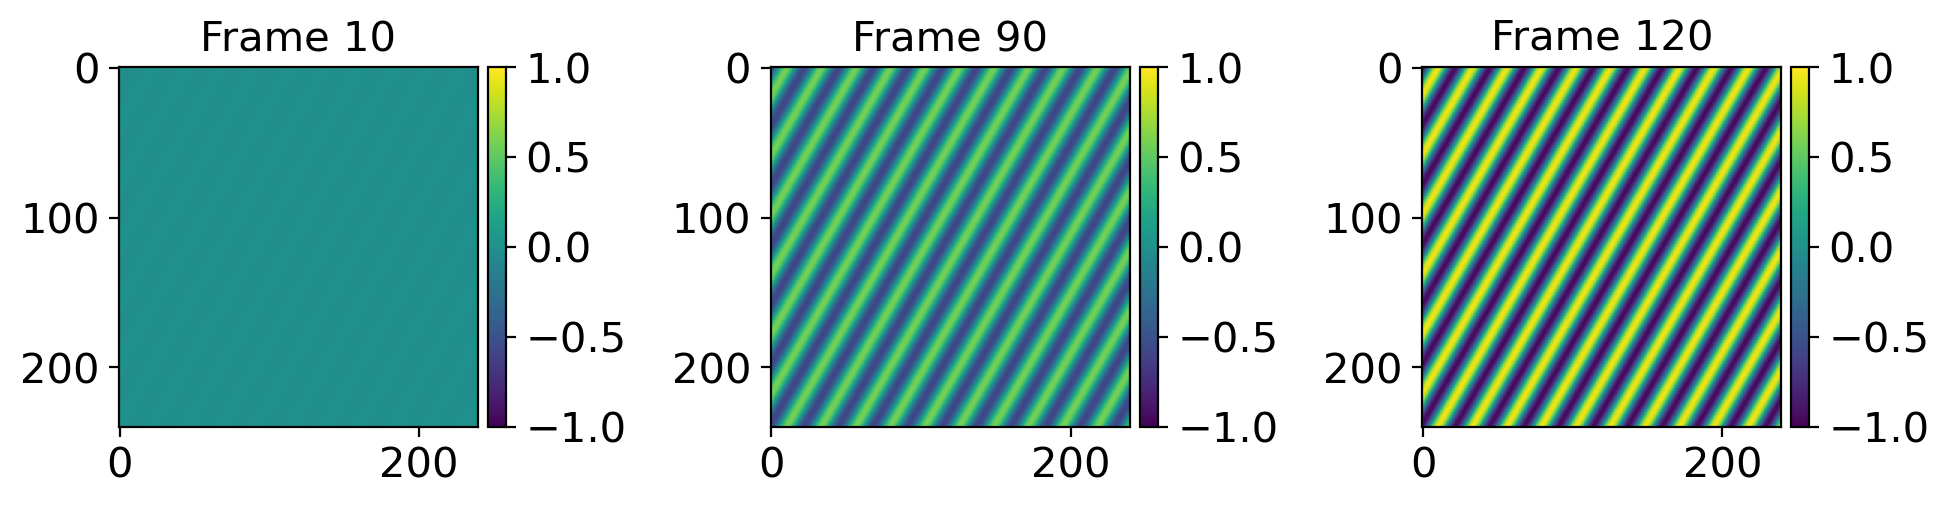

In [9]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, dpi=100, figsize=(10,3))

def plot_frame(ax, i):
    im = ax.imshow(grating_video[:, :, i], vmin=-1, vmax=1)
    ax.set_title('Frame %d' % i)
    add_colorbar(ax, im)

plot_frame(ax1, 10)
plot_frame(ax2, 90)
plot_frame(ax3, 120)

plt.tight_layout()
plt.show()

### Visualizing a single pixel over time

In [10]:
# y-coordinate is fixed to middle row; vary x-coordinate to see its value over time

def _(x_coordinate):
    plt.plot(time, grating_video[n_size//2, x_coordinate, :], color='C2')
    plt.xlabel('Time [s]')
    plt.ylabel('Pixel Value')
    plt.ylim(-1,1)
    plt.show()
    
interact(_, x_coordinate=IntSlider(value=n_size//2, min=0, max=n_size, step=1, continuous_update=False));

interactive(children=(IntSlider(value=120, continuous_update=False, description='x_coordinate', max=240), Outp…

### Visualizing the centre column over time

Left and right, you can see the effect of the temporal ramping; top and bottom, the effect of the spatial Gaussian.

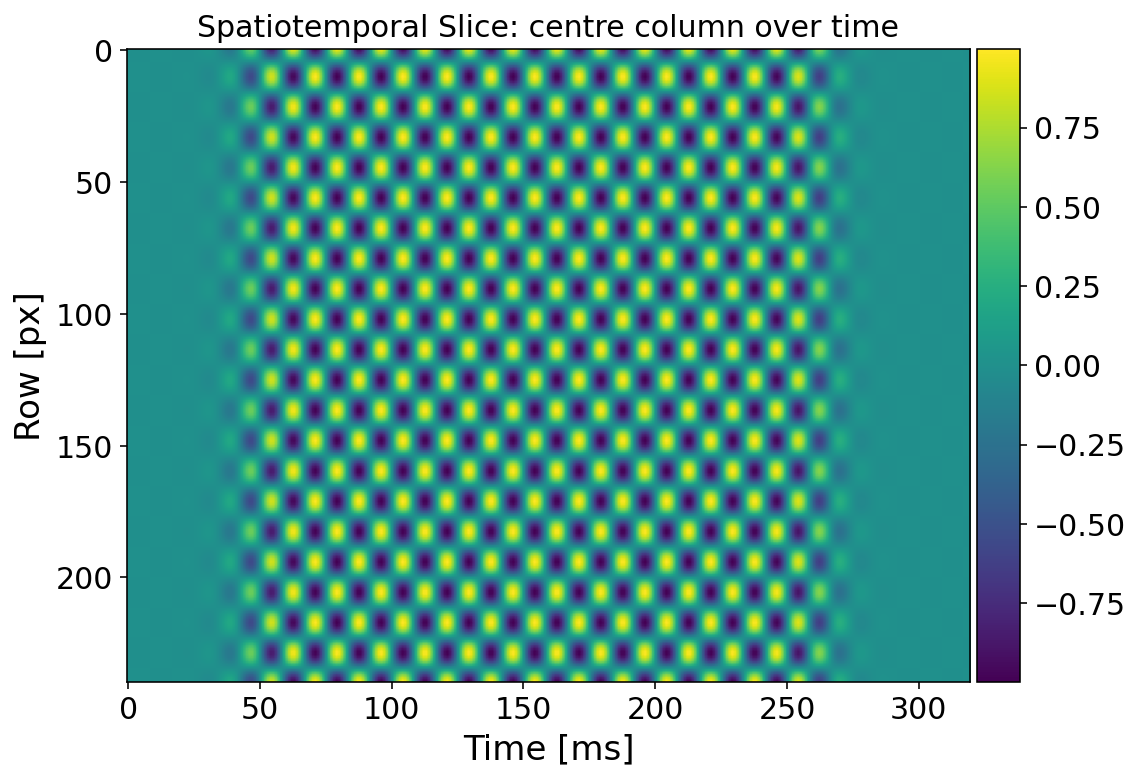

In [11]:
def plot_spatiotemporal_slice(grating_video, ax, title=""):
    st_slice = grating_video[n_size//2, :, :]
    im = ax.imshow(st_slice)
    ax.set_xlabel("Time [ms]")
    ax.set_ylabel("Row [px]")
    ax.set_title(title)
    add_colorbar(ax, im)

fig = plt.figure(figsize=(8, 8))
plot_spatiotemporal_slice(grating_video, fig.gca(), "Spatiotemporal Slice: centre column over time")
plt.show()

### Visualize video as spationtemporal cube

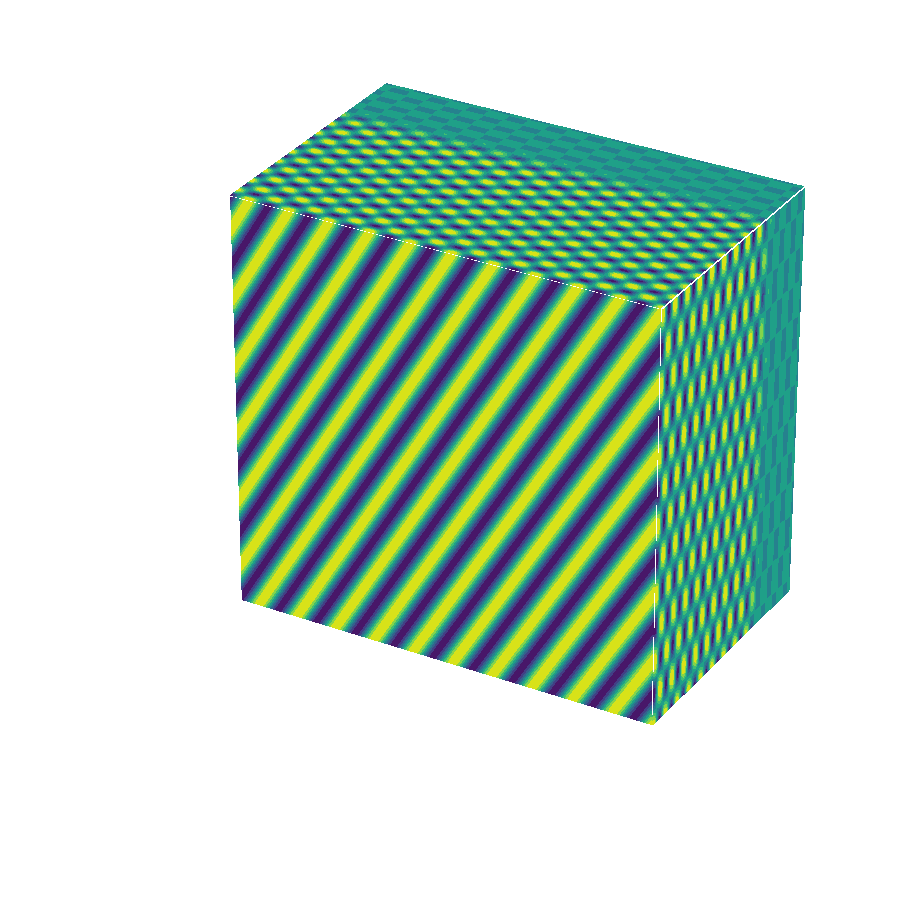

In [12]:
def plot_cube(data, t_offset=0, with_axis=False):
    fig = plt.figure(figsize=(8,8))
    ax = fig.gca(projection='3d')
    
    X = np.arange(data.shape[0])
    Y = np.arange(data.shape[1])
    Z = np.arange(t_offset, data.shape[2])

    cset = [[],[],[]]

    XX, ZZ = np.meshgrid(X, Z)
    V = np.swapaxes(data[-1,:,t_offset:], 0, 1)
    ax.contourf(XX, ZZ, V, zdir='z', offset=-1, vmin=data.min(), vmax=data.max())

    ZZ, YY = np.meshgrid(Z, Y)
    V = data[:,-1,t_offset:]
    ax.contourf(V, ZZ, YY, zdir='x', offset=n_size, vmin=data.min(), vmax=data.max())

    XX, YY = np.meshgrid(X, Y)
    V = data[:,:,t_offset]
    ax.contourf(XX, V, YY, zdir='y', offset=t_offset, vmin=data.min(), vmax=data.max())

    # setting 3D-axis-limits:    
    ax.set_xlim3d(0, data.shape[1])
    ax.set_ylim3d(0, data.shape[2])
    ax.set_zlim3d(0, data.shape[0])
    ax.invert_zaxis()

    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_zticklabels([])
    plt.axis('on' if with_axis else 'off')

    plt.show()
    
    
plot_cube(grating_video, 120)

# Spatial Kernel

The spatial filter is defined as a difference of Gaussians (`gaussian_filter` plugged into `spatial_kernel`). All relevant parameters for the spatial kernels of M and P cells are given in the paper.

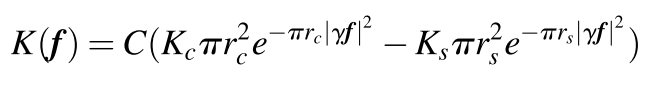

This formula, along with the parameter values, have been adopted from Croner & Kaplan (1995), where the unit of the r values is given as _deg_ and the unit of the K values as _imp sec^-1 %contrast^-1 deg^-2_ in Table 1.

We implement the kernel both in the frequency domain (using the formula given in the paper), as well as in the spatial domain (using Matlab code sent to us by Casile). We then Fourier-transform each implementation into the other domain. (Note the naming convenction `..._f2s` for the frequency domain implementation transformed to the spatial domain, and so on.) Ideally, they would transform into one another. For reasons to be discussed, this is not the case.

In [13]:
# Parameters from Casile et. al, adopted from Croner & Kaplan (1995)
# K: peak sensitivities of gauss
# r: radius of gauss

# Casile set C to C=1.
C = 1.

# Parameters M cells:
Kc_m = 148.
rc_m = 0.1
Ks_m = 1.1
rs_m = 0.72

# Parameters P cells:
Kc_p = 325.2  # number from his code paper: 353.2
rc_p = 0.03
Ks_p = 4.4
rs_p = 0.18

### Spatial kernel in frequency domain

In [14]:
def spatial_kernel_f(f, C, Kc, rc, Ks, rs, gamma=0.5):
    """
    Spatial kernel in frequency domain as a difference of Gaussians.
    Direct implementation of the given formula.
    parameters
    ------------
    f - frequency array [c/d]
    C - contrast of stimulus
    Kc, Ks - peak sensitivities of Gaussians (center, surround)
    rc, rs - radius of Gaussians [deg] (center, surround)
    gamma - scaling factor to model smaller RF size at the fovea (bigger gamma -> magnified RF)
    """
    
    def gaussian(K, r):
        exponent = -np.pi * r * (gamma * f)**2
        return K * np.pi * r**2 * np.exp(exponent)
    
    return C * (gaussian(Kc, rc) - gaussian(Ks, rs))

In [15]:
def transform_f2s(k):
    """Fourier-transform the spatial kernel from frequency to spatial domain."""
    k = ifftshift(k)
    k = ifftn(k)
    k = fftshift(k)
    k = np.real(k)
    return k

### Frequency input matrix
The value of `f[i,j]` is the frequency (in c/d) that the coordinates `[i,j]` are associated with in the frequency domain (shifted, so that zero-frequency is in the center).

By using `fftfreq`, we assure that the resulting kernel is consistently compatible with the inputs. The `d` parameter is the sample spacing, i.e. the distance (in the desired unit, degrees) between two samples in the spatial domain (= pixels).

In [16]:
# set up frequency basis matrix as described above

f_1d = fftshift(fftfreq(n_size, d=deg_per_px)) # 1D frequencies in each dimension
fx, fy = np.meshgrid(f_1d, f_1d)
f = np.sqrt(fx**2 + fy**2)

# for plotting purposes
_f = np.round(f_1d)
f_extent = (_f[0], _f[-1], _f[0], _f[-1])

In [17]:
# For M cells:
skernel_m_f = spatial_kernel_f(f, C, Kc_m, rc_m, Ks_m, rs_m)
skernel_m_f2s = transform_f2s(skernel_m_f)

# For P cells:
skernel_p_f = spatial_kernel_f(f, C, Kc_p, rc_p, Ks_p, rs_p)
skernel_p_f2s = transform_f2s(skernel_p_f)

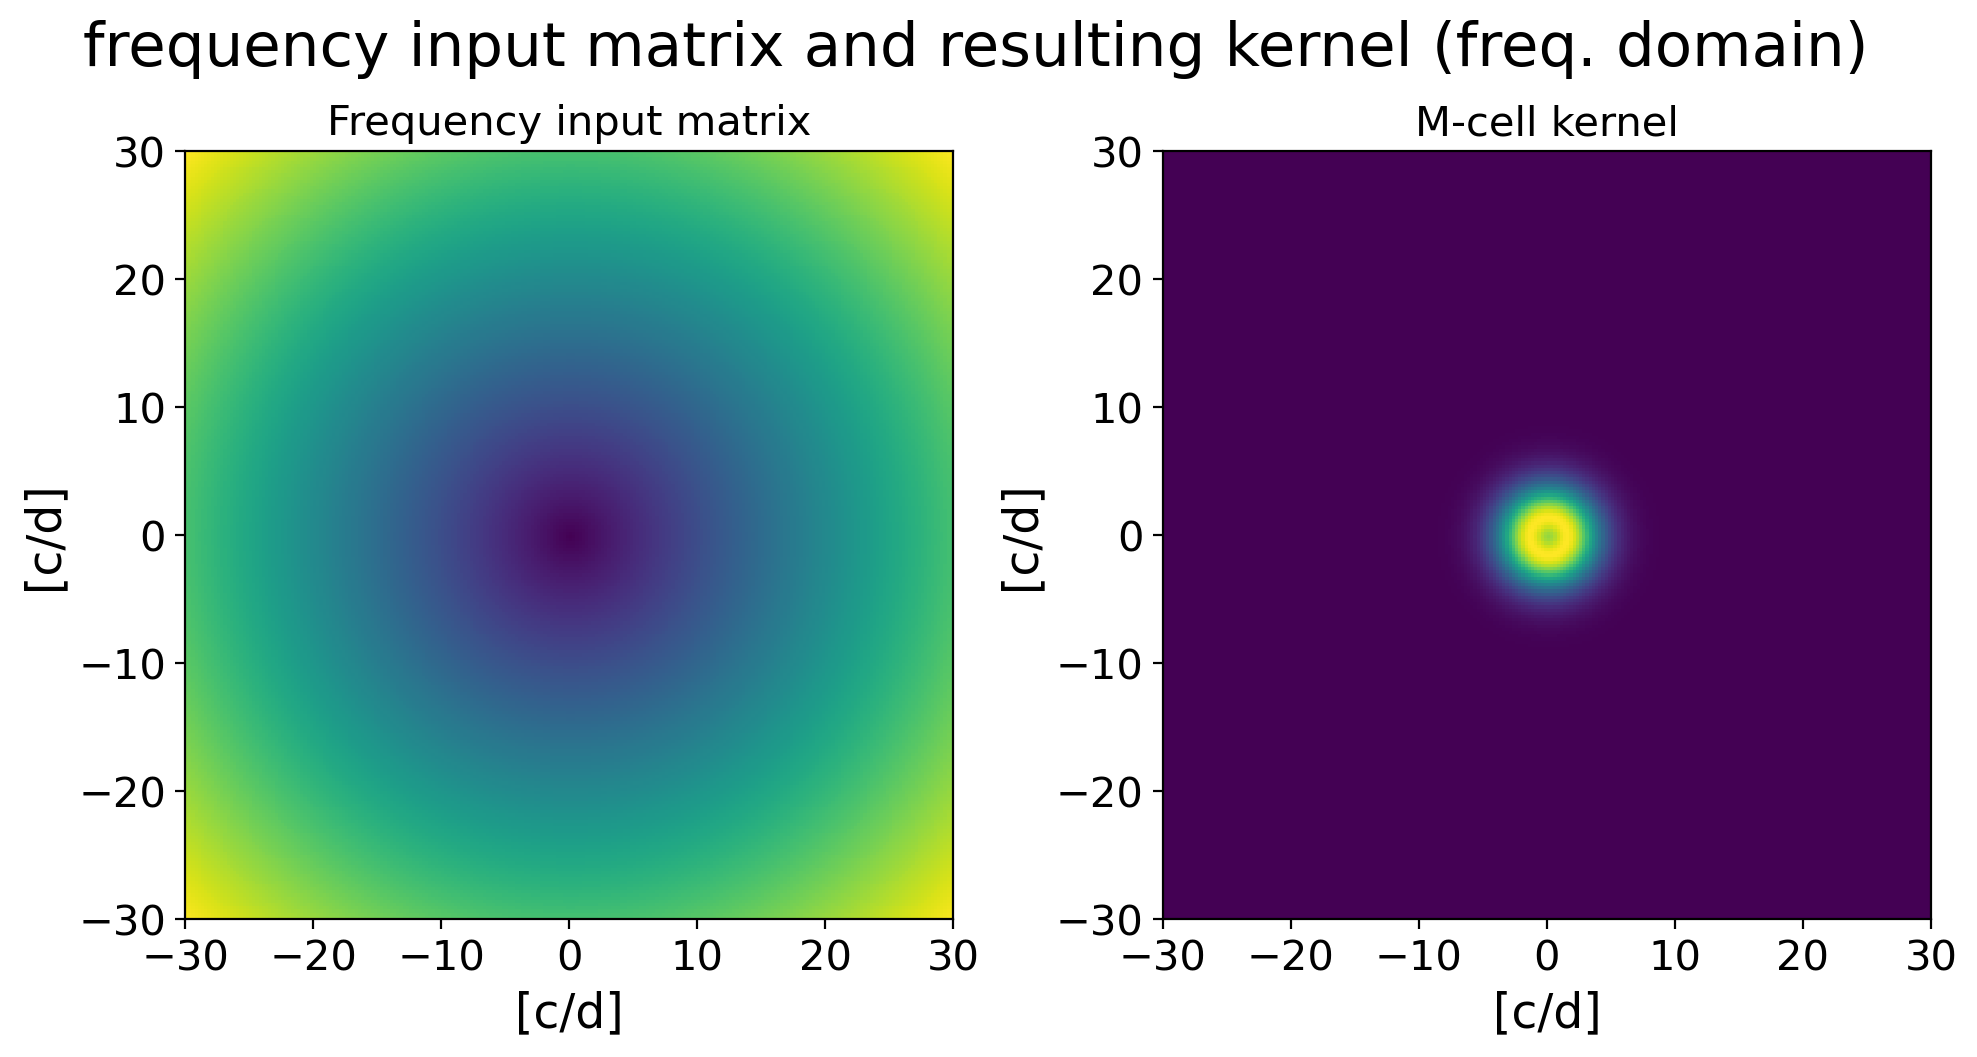

In [18]:
# plot frequency input matrix and resulting kernel
fig, [ax1, ax2] = plt.subplots(1, 2, dpi=100, figsize=(10, 5))
plt.suptitle('frequency input matrix and resulting kernel (freq. domain)', y=1.05)

ax1.set_xlabel('[c/d]');ax1.set_ylabel('[c/d]')
ax2.set_xlabel('[c/d]');ax2.set_ylabel('[c/d]')

ax1.set_title('Frequency input matrix')
ax1.imshow(f, extent=f_extent)

skernel_m_f = spatial_kernel_f(f, C, Kc_m, rc_m, Ks_m, rs_m)
ax2.set_title('M-cell kernel')
ax2.imshow(skernel_m_f, extent=f_extent)

plt.tight_layout()
plt.show()

### Spatial kernel in spatial domain

This implementation is based on the Matlab implementation sent to us by Casile. The formula used (spatial domain) does not appear to be the Fourier transform of the kernel formula given in the paper (frequency domain); i.e. when we analytically transformed the formula above into the spatial domain, it is not obvious whether the code below corresponds to that transformed formula.

In the implementation, the r values are converted from degrees to pixels. The K values (whose units also involve degrees, see above) on the other hand are not adjusted. (Attempts to convert them have not lead to consistent results either.) This raises the possibility that the implementation at hand may not be an accurate implementation of the kernel given by Croner & Kaplan (1995).

Also, in the Matlab implementation sent to us by Casile, a parameter `sFactor` is used, which is `gamma` in the formula. Playing around with different values for `sFactor` and `gamma`, combined with "zooming in"/"cutting out" to account for differences in scale, have not led to congruence amongst the two implementations. Using the value of `gamma=0.5` from the paper leads to a tiny kernel compared to the frequency domain implementation.

Lastly, there is also a copying error in the parameter data taken from Kroner & Kaplan (1995): K_c of M cells is given as 353.2, but should be 325.2.

In [19]:
def spatial_kernel_s(RF_size, C, Kc, rc, Ks, rs, sFactor=0.5):
    """
    Spatial kernel in spatial domain as a difference of Gaussians.
    Based on Matlab implementation by Casile.
    parameters
    ------------
    RF_size - size of kernel [deg]
    C - contrast of stimulus
    Kc, Ks - peak sensitivities of Gaussians (center, surround)
    rc, rs - radius of Gaussians [deg] (center, surround)
    sFactor - scaling factor to model smaller RF size at the fovea (bigger sFactor -> magnified RF)
    """
    # convert to px
    rc = rc * px_per_deg
    rs = rs * px_per_deg
    #Kc = Kc / px_per_deg**2
    #Ks = Ks / px_per_deg**2
    RF_size = RF_size * px_per_deg
    
    # place receptive field at the center of the grid
    center_x = np.floor(RF_size/2.) 
    center_y = np.floor(RF_size/2.)
    
    # "input grid" for DoG
    XX, YY = np.meshgrid(np.arange(0, RF_size), np.arange(0, RF_size))
    XX = (XX - center_x) / sFactor
    YY = (YY - center_y) / sFactor
    
    def gaussian(K, r):
        return K * np.exp( -(XX**2 + YY**2)/(r**2) )

    k = C * (gaussian(Kc, rc) - gaussian(Ks, rs))
    p = int((n_size-RF_size)/2)
    return np.pad(k, ((p, p), (p, p)))

In [20]:
def transform_s2f(k):
    """Fourier-transform the spatial kernel from spatial to frequency domain."""
    k = ifftshift(k)
    k = fftn(k)
    k = fftshift(k)
    k = np.real(k)
    return k

In [21]:
# For M cells:
skernel_m_s = spatial_kernel_s(1, C, Kc_m, rc_m, Ks_m, rs_m)
skernel_m_s2f = transform_s2f(skernel_m_s)

# For P cells:
skernel_p_s = spatial_kernel_s(1, C, Kc_p, rc_p, Ks_p, rs_p)
skernel_p_s2f = transform_s2f(skernel_p_s)

### Visualize both kernel implementations

- Top row: Frequency domain
- Bottom row: Spatial domain
- Left column: Implementations themselves
- Right column: Fourier transforms (diagonally, i.e. top-right is FT of bottom-left)

In [22]:
@interact(M_or_P=False)
def _(M_or_P):
    fig, [[ax11, ax12], [ax21, ax22]] = plt.subplots(2, 2, dpi=100, figsize=(10, 10))
    plt.suptitle('Kernels for %s cells' % ('M' if M_or_P else 'P'), y=1.05)
    ax11.set_title('Frequency Domain')
    ax12.set_title('Frequency Domain (transformed)')
    ax21.set_title('Spatial Domain')
    ax22.set_title('Spatial Domain (transformed)')
    freq_label = '[c/d]'
    ax11.set_xlabel(freq_label);ax11.set_ylabel(freq_label)
    ax12.set_xlabel(freq_label);ax12.set_ylabel(freq_label)
    spat_label = '[px]'
    ax21.set_xlabel(spat_label);ax21.set_ylabel(spat_label)
    ax22.set_xlabel(spat_label);ax22.set_ylabel(spat_label)
    
    if M_or_P:
        im11 = ax11.imshow(skernel_m_f, extent=f_extent)
        im12 = ax12.imshow(skernel_m_s2f, extent=f_extent)
        im21 = ax21.imshow(skernel_m_s)
        im22 = ax22.imshow(skernel_m_f2s)
    else:
        im11 = ax11.imshow(skernel_p_f, extent=f_extent)
        im12 = ax12.imshow(skernel_p_s2f, extent=f_extent)
        im21 = ax21.imshow(skernel_p_s)
        im22 = ax22.imshow(skernel_p_f2s)
        
    add_colorbar(ax11, im11)
    add_colorbar(ax12, im12)
    add_colorbar(ax21, im21)
    add_colorbar(ax22, im22)
        
    plt.tight_layout()
    plt.show()

interactive(children=(Checkbox(value=False, description='M_or_P'), Output()), _dom_classes=('widget-interact',…

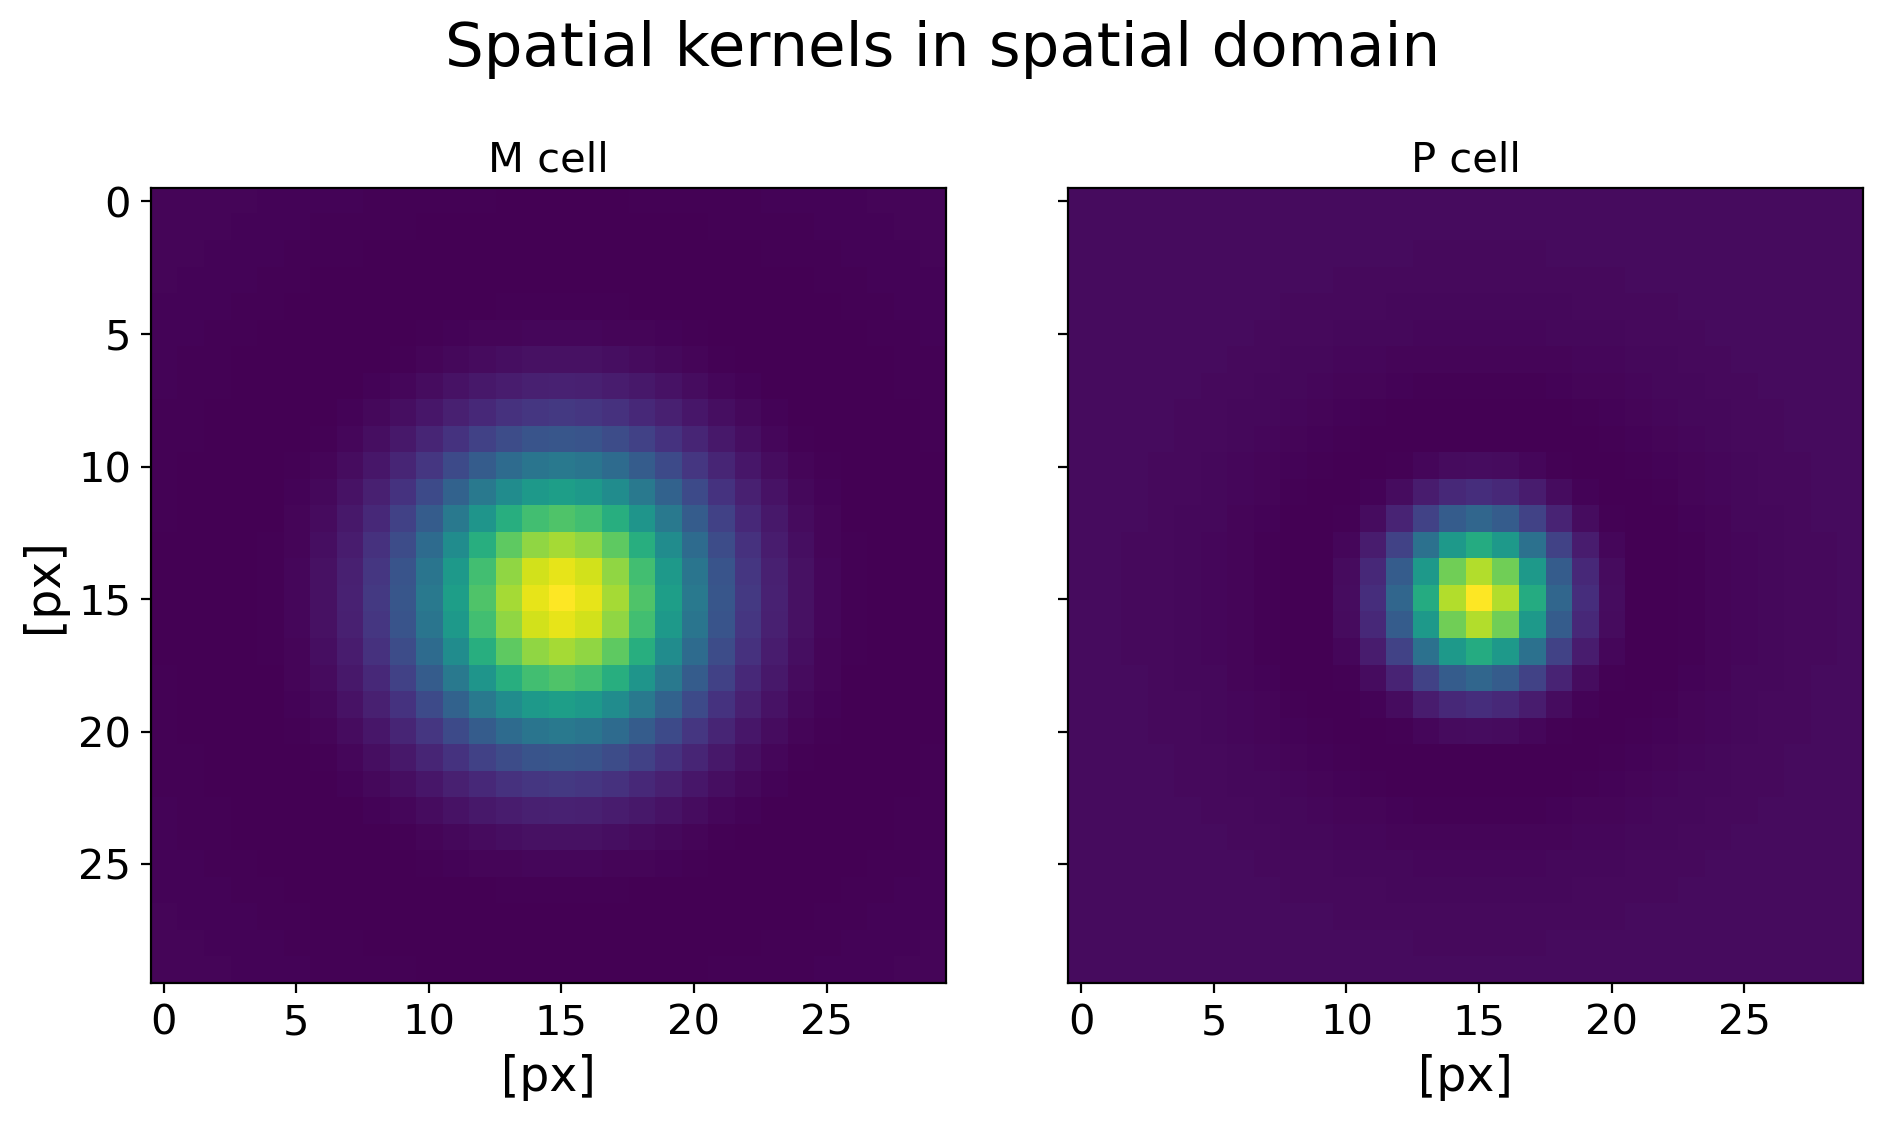

In [23]:
# here is a zoomed in version of the kernels (frequency domain implementation transformed into spatial domain)
fig, [ax1, ax2] = plt.subplots(1, 2, dpi=100, figsize=(10, 5), sharey=True)
plt.suptitle('Spatial kernels in spatial domain', y=1.1)
ax1.imshow(skernel_m_f2s[105:135,105:135])
ax1.set_title('M cell')
ax1.set_xlabel('[px]')
ax1.set_ylabel('[px]')
ax2.imshow(skernel_p_f2s[105:135,105:135])
ax2.set_title('P cell')
ax2.set_xlabel('[px]')
plt.tight_layout()
plt.show()

### Visualize spatial kernels in frequency domain in one dimension

Since the kernel is circular symmetric by construction, we can visualize it in one dimension by plotting the center row.

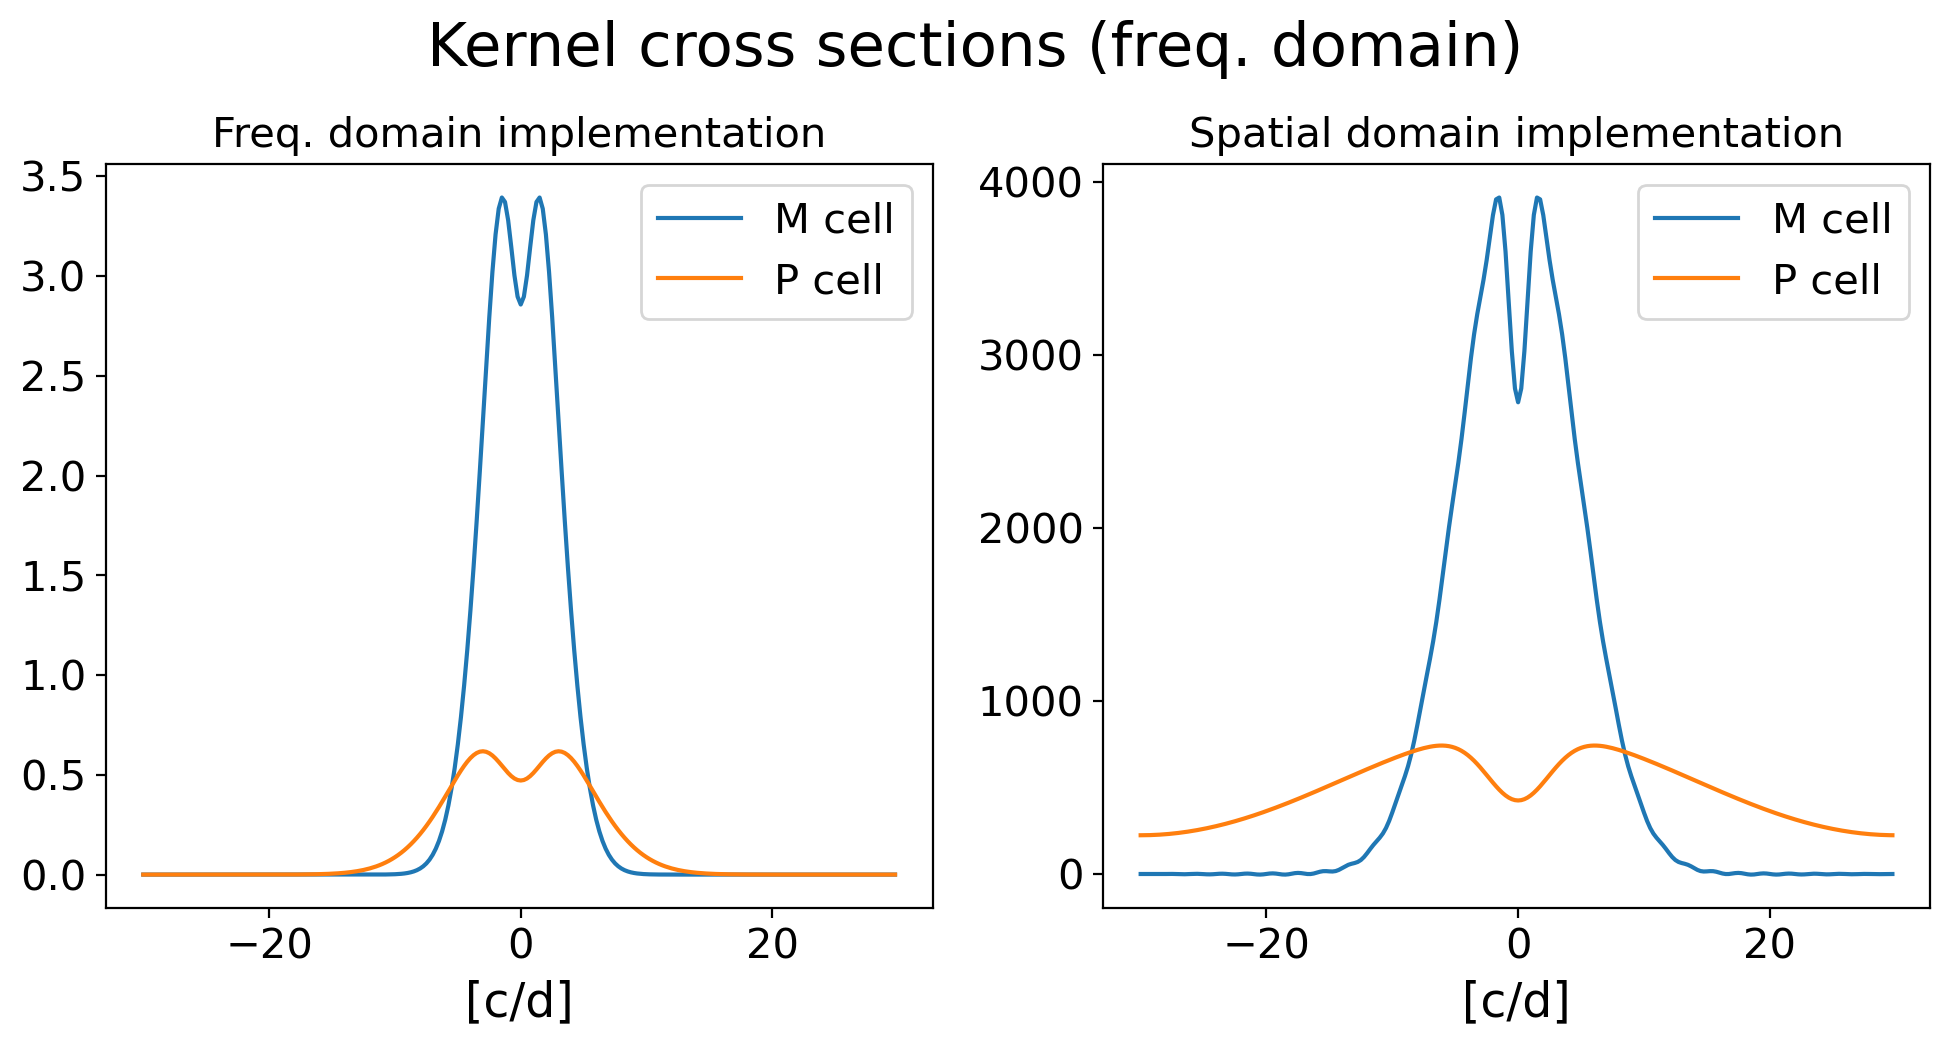

In [24]:
fig, [ax1, ax2] = plt.subplots(1, 2, dpi=100, figsize=(10, 5))
plt.suptitle('Kernel cross sections (freq. domain)', y=1.05)

ax1.set_title('Freq. domain implementation')
ax1.plot(f_1d, skernel_m_f[n_size//2], label='M cell')
ax1.plot(f_1d, skernel_p_f[n_size//2], label='P cell')
ax1.set_xlabel('[c/d]')
ax1.legend()

ax2.set_title('Spatial domain implementation')
ax2.plot(f_1d, skernel_m_s2f[n_size//2], label='M cell')
ax2.plot(f_1d, skernel_p_s2f[n_size//2], label='P cell')
ax2.set_xlabel('[c/d]')
ax2.legend()

plt.tight_layout()
plt.show()

("Texan Hat Function" https://i.redd.it/ulqzhfv6j6g21.png)

# Temporal Kernels

The temporal filter is a combination of the high and low pass filters (`high_pass_filter` and `low_pass_filter`, respectively). All relevant parameters for the temporal kernels of M and P cells are given in the paper.

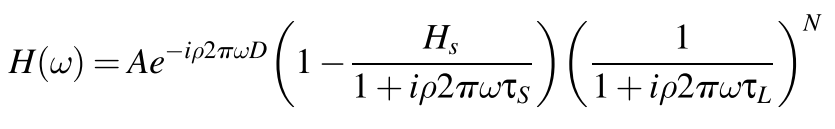

(However, the paper doesn't specify the units of the parameters of any of the kernels, and the values given for `D`, `tau_L`, and `tau_S` are given in milliseconds, but in order to construct the kernels, the values need to be transformed into seconds.)

In [25]:
# Parameters from Casile et. al

# This rho is reported in the paper, but problems while reproducing the plots below, 
# raise the question whether this is the value usd
rho = 1./1.6

# Parameters M cells:
N_m = 30.
A_m = 499.77
H_s_m = 1.
# Transform into seconds:
D_m = 2. / 1000.
tau_L_m = 1.1 / 1000.
tau_S_m = 2.23 / 1000.

# Parameters P cells:
N_p = 38.
A_p = 67.59
H_s_p = 0.69
# Transform into seconds:
D_p = 3.5 / 1000.
tau_L_p = 1.27 / 1000.
tau_S_p = 29.36 / 1000.

### Temporal Kernel in Frequency Domain

Analogous to the spatial kernels, we now implement the given formula, a transform into the temporal domain, and instantiate and transform the M and P cell kernels.

The value of `omega[i]` is the frequency (in Hz) that the index `[i]` is associated with in the frequency domain (shifted, so that zero-frequency is in the center).

By using `fftfreq`, we assure that the resulting kernel is consistently compatible with the inputs. The `d` parameter is the sample spacing, i.e. the distance (in the desired unit, seconds) between two samples in the spatial domain (= frames).

In [26]:
omega = fftshift(fftfreq(n_time, d=dt))

In [27]:
def temporal_kernel_f(omega, rho, A, D, H_s, tau_S, tau_L, N):
    """
    Calculate the temporal kernal as a series of low-pass filters and one high-pass stage (Victor, 1987).
    parameters
    omega - frequency basis array [Hz]
    rho, A, D, H_s, tau_S, tau_L, N - see the referenced papers
    """
    prefix = A * np.exp(-1j * rho * 2 * np.pi * omega * D)
    high_pass_filter = 1 - (H_s / (1 + 1j * rho * 2 * np.pi * omega * tau_S))
    low_pass_filters = (1 / (1 + 1j * rho * 2 * np.pi * omega * tau_L))**N
    
    return prefix * high_pass_filter * low_pass_filters

In [28]:
def transform_f2t(k):
    """Transform temporal kernel from frequency to temporal domain."""
    k = ifftshift(k)
    k = ifft(k)
    return np.real(k)

In [29]:
# omega determines the sample rate (and equivalently the maximum temporal frequency) of the kernel;
# rho is a scaling factor;
# therefore, we create getter functions to easily play around with the size/granularity of the kernel for plotting
# (really just wrapper functions filling in most params; setting default values would be another option)

# M cells:
def get_tkernel_m_f(_omega, _rho=rho):
    return temporal_kernel_f(_omega, _rho, A_m, D_m, H_s_m, tau_S_m, tau_L_m, N_m)

tkernel_m_f = get_tkernel_m_f(omega, rho)
tkernel_m_f2t = transform_f2t(tkernel_m_f)


# P cells:
def get_tkernel_p_f(_omega, _rho=rho):
    return temporal_kernel_f(_omega, _rho, A_p, D_p, H_s_p, tau_S_p, tau_L_p, N_p)

tkernel_p_f = get_tkernel_p_f(omega, rho)
tkernel_p_f2t = transform_f2t(tkernel_p_f)

### Visualize kernels in frequency domain

Note on dB: Since the values of the frequency domain are amplitudes, the dB ratio formula is given by 

$$Ratio_{dB} = 20 \cdot (log_{10}( \text{signal} / \text{reference} ))$$

(see https://www.rapidtables.com/electric/decibel.html).

"In practical signal processing, it is common to choose the maximum signal magnitude as the reference amplitude." (https://www.dsprelated.com/freebooks/mdft/Decibels.html).

The graph below should be ideally be identical to the graph from the paper plotted below that for reference (plotting data for that graph are not available). Playing around with different values for `omega` and `rho` have not lead to perfect congruence. The closest match for reasonable values happens when we use an `omega` corresponding to a framerate of 100fps and `rho=1`, despite `rho=1/1.6` being given in the paper.

In [30]:
def to_db(x):
    x = np.abs(x)
    return 20*np.ma.log10(x/x.max())

@interact(sample_rate=IntSlider(min=100, max=150, continuous_update=False),
    _rho=[('1.0', 1.0), ('1/1.6', 1./1.6)])
def _(sample_rate, _rho):
    plt.figure(figsize=(8,6))

    _omega = fftshift(fftfreq(n_time, d=1/sample_rate))

    plt.plot(omega, to_db(get_tkernel_m_f(_omega, _rho)), '-', linewidth=4, label='M cell')
    plt.plot(omega, to_db(get_tkernel_p_f(_omega, _rho)), '-', linewidth=4, label='P cell')

    plt.legend(loc='lower right')
    plt.title('Temporal kernels in frequency domain')
    plt.ylabel('Sensitivity [dB]')
    plt.xlabel('Temporal frequency [Hz]')

    plt.xscale('log')
    plt.gca().xaxis.set_major_formatter(ScalarFormatter())
    plt.gca().xaxis.set_ticks([1,3,10,50])
    plt.ylim(-40, 1)
    plt.gca().yaxis.set_major_formatter(ScalarFormatter())

    plt.show()

interactive(children=(IntSlider(value=100, continuous_update=False, description='sample_rate', max=150, min=10…

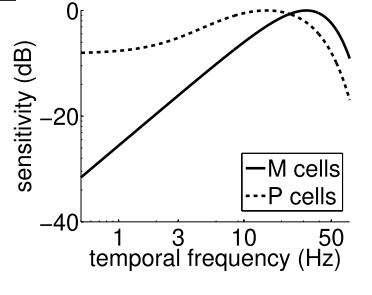

(Why are the ticks on the y-ordinate logarithmic, when the values are linear? dB basically turns a logarithmic scale into a linear one, so this is probably a small error.)

### Visualize kernels in temporal domain

The dotted lines show the actual granularity of the kernel (given the framerate), as it would be applied during convolution.

In [31]:
@interact(_rho=[('1.0', 1.0), ('1/1.6', 1./1.6)])
def _(_rho):
    kernel_length = 150 # relevant (non-zero) length in ms
    t = np.arange(0, kernel_length, 1000*dt)

    # kernels
    _tkernel_m_f2t = transform_f2t(get_tkernel_m_f(omega, _rho))
    _tkernel_p_f2t = transform_f2t(get_tkernel_p_f(omega, _rho))

    # fine-grained kernels
    t_fine = np.arange(0, kernel_length, 100*dt)
    omega_fine = fftshift(fftfreq(n_time, d=dt/10))
    tkernel_m_f2t_fine = transform_f2t(get_tkernel_m_f(omega_fine, _rho))
    tkernel_p_f2t_fine = transform_f2t(get_tkernel_p_f(omega_fine, _rho))


    # fit fine kernels to real kernels
    tkernel_m_f2t_fine = (tkernel_m_f2t_fine / tkernel_m_f2t_fine.max()) * _tkernel_m_f2t.max()
    tkernel_p_f2t_fine = (tkernel_p_f2t_fine / tkernel_p_f2t_fine.max()) * _tkernel_p_f2t.max()


    fig, [ax1, ax2] = plt.subplots(1, 2, dpi=100, figsize=(10,5), sharey=True)
    plt.suptitle('Temporal kernels in temporal domain', y=1.05)
    ax1.set_xlabel('Time [ms]')
    ax2.set_xlabel('Time [ms]')

    ax1.plot(t_fine, tkernel_m_f2t_fine[:len(t_fine)], color='C0', linewidth=3)
    ax1.plot(t, _tkernel_m_f2t[:len(t)], '--', color='black', linewidth=1)
    ax1.set_title('M Cell')

    ax2.plot(t_fine, tkernel_p_f2t_fine[:len(t_fine)], color='C1', linewidth=3)
    ax2.plot(t, _tkernel_p_f2t[:len(t)], '--', color='black', linewidth=1)
    ax2.set_title('P Cell')

    plt.show()

interactive(children=(Dropdown(description='_rho', options=(('1.0', 1.0), ('1/1.6', 0.625)), value=1.0), Outpu…

# Radial Averaging

Before we apply the kernels, we want to explain our implementation of radial averaging. In the 2D frequency domain, the radius of each pixel corresponds to a frequency. In order to reduce the spatial dimension from 2 to 1, we average the values of all pixels that correspond to the same frequency (rounded, to reduce numerical problems).
This is visualized by in the interactive plot below, where the thickness of the ring is determined by the frequency rounding factor. The function `radial_average` computes the averages of all rings and returns their average.

In [32]:
def radial_mean(x, radii, rounding_factor=0.25, only_full_circles=True):
    """
    Radial mean of a 2D array. Values with equal (rounded) radii will be assigned to bins, of
    which then the mean will be calculated.
    parameters
    ------------
    x - 2D array of values to be averaged
    radii - same shape as x containing the radius of each pixel, over which to average
    rounding_factor - determines the granularity of the bins
    only_full_circles - exclude radius bins greater than the maximal width/height radius
    
    returns
    ---------
    means - 1D array; mean of each radius bin
    bins - 1D array; radius of each bin
    """
    
    # create bins by rounding to int
    radii = (radii / rounding_factor).astype(int)

    # creates bins from 0 to radii.max(); for all i, adds x[i] to sum_bins[radii[i]]
    sum_bins = np.bincount(radii.ravel(), x.ravel())

    # count how often a radius is represented
    count_bins = np.bincount(radii.ravel())
    
    # mean of each radius bin
    means = np.ma.divide(sum_bins, count_bins)

    # radius each bin represents
    bins = np.arange(0, means.count()) * rounding_factor
    
    if only_full_circles:
        max_bin = min(radii[0, :].min(), radii[:, 0].min(), radii[-1, :].min(), radii[:, -1].min())
        means = means[:max_bin]
        bins = bins[:max_bin]
    
    return means, bins

In [33]:
# Radial averaging visualization

grating_s = create_grating(10., np.pi/3, 0.) # spatial frequency of grating: 10 c/d
rounding_factor = 0.5
grating_f = np.abs(fftshift(fftn(grating_s)))

def _(freq, only_full_circles=False):
    gf_mean, gf_f = radial_mean(grating_f, f, 
        rounding_factor=rounding_factor, only_full_circles=only_full_circles)

    f_rounded = (f/rounding_factor).astype(int) * rounding_factor
    
    ring_mask = f_rounded == freq
    ring = np.ones_like(grating_f)
    ring = np.ma.masked_where(~ring_mask, ring)
    
    ring_mean = grating_f[ring_mask].mean()
    
    fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(20, 5))
    
    ax1.imshow(grating_s)
    ax1.set_xlabel('[px]')
    ax1.set_ylabel('[px]')
    ax1.set_title('Spatial grating (10 c/d)')
    
    im = ax2.imshow(np.log(grating_f+0.001), extent=f_extent)
    ax2.imshow(ring, cmap='binary', interpolation='none', extent=f_extent)
    ax2.set_xlabel('[c/d]')
    ax2.set_ylabel('[c/d]')
    add_colorbar(ax2, im)
    ax2.set_title('Frequency domain of grating')
    
    ax3.plot(gf_f, gf_mean, label='radial_mean()')
    ax3.plot(freq, ring_mean, 'o', label='mean of current ring')
    ax3.set_xlabel('[c/d]')
    ax3.set_yscale('log')
    ax3.set_title('Radially averaged spectrum')
        
    ax3.legend()
    
    plt.show()
    

interact(_, freq=FloatSlider(value=10, min=0, max=40, step=1, continuous_update=False), only_full_circles=True);

interactive(children=(FloatSlider(value=10.0, continuous_update=False, description='freq', max=40.0, step=1.0)…

### Second spike and edge effects

The second spike is largely due to edge effects (i.e. because the grating isn't a continous sinusoid, but a discrete image with hard egdes, influencing the spatial frequency spectrum. We now explore ways to combat these edge effects, namely: (1) super-sampling, in effect zero-padding the input image before Fourier transforming it, and (2) applying a spatial Gaussian to the input image, turning the sinusoid into a Gabor patch.

Quick note on (super-)sampling: The discrete Fourier transform between the spatial and frequency domain is loss-free, when the dimensions of the arrays in both domains are identical (hence it's the default for all Fourier implementations). It is however possible to "supersample", i.e. to have the size of the frequency domain representation to be greater than the original image in the spatial domain. This is realized by zero-padding the image before applying the Fourier transform.

In this case, super-sampling does not appear to affect the resulting frequency spectrum other than in its smoothness.

In [34]:
# Radial averaging: edge effects

def _(sampling_factor=1, gabor=False):
    grating_s = create_grating(10., np.pi/3, 0.)
    if gabor:
        grating_s = add_spatial_gaussian(grating_s, sigma=0.25)
    rounding_factor = 0.5
    
    grating_f = np.abs(fftshift(fftn(grating_s, (n_size*sampling_factor, n_size*sampling_factor))))
    
    f_1d = fftshift(fftfreq(n_size*sampling_factor, d=deg_per_px)) # 1D frequencies in each dimension
    fx, fy = np.meshgrid(f_1d, f_1d)
    f = np.sqrt(fx**2 + fy**2)

    gf_mean, gf_f = radial_mean(grating_f, f, 
        rounding_factor=rounding_factor, only_full_circles=True)

    f_rounded = (f/rounding_factor).astype(int) * rounding_factor
    
    fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(20, 5))
    
    ax1.imshow(grating_s)
    ax1.set_xlabel('[px]')
    ax1.set_ylabel('[px]')
    
    im = ax2.imshow(np.log(grating_f+0.001), extent=f_extent)
    ax2.set_xlabel('[c/d]')
    ax2.set_ylabel('[c/d]')
    add_colorbar(ax2, im)
    
    ax3.plot(gf_f, gf_mean, label='radial_mean()')
    ax3.set_xlabel('[c/d]')
    ax3.set_yscale('log')
    if gabor:
        ax3.set_ylim(1e-9, 1e+3)
    else:
        ax3.set_ylim(1e-1, 1e+3)
    
    ax3.legend()
    
    plt.show()
    

interact(_, sampling_factor=IntSlider(min=1, max=5, step=1, continuous_update=False), gabor=False);

interactive(children=(IntSlider(value=1, continuous_update=False, description='sampling_factor', max=5, min=1)…

# Apply the kernels

We will now apply both kernels by multiplying in the frequency domain (which corresponds to convolution with periodic boundary conitions). We will apply the spatial kernel to a single grating and the temporal kernel to a single pixel, before applying both to the entire example video.

### Apply spatial kernels to a single grating

We create a new grating (to easily vary the parameters) and apply the kernels. We show the effect on the kernels in the frequency domain (radially-averaged frequencies in a double-log plot) and the spatial domain.

When `alpha` is set to 0, we can see in the last plot, that in the spatial domain the kernels do not change the shape, but only the amplitude of the grating.

In [35]:
@interact_manual(freq=(0.5, 10., 0.5), alpha=(0, np.pi, np.pi/12), phi=(0, np.pi, np.pi/12), gabor=False)
def _(freq=2., alpha=0., phi=0., gabor=False):
    # create grating
    grating_s = create_grating(freq, alpha, phi)
    if gabor:
        grating_s = add_spatial_gaussian(grating_s, sigma=.25)
    
    # calculate Fourier transforms, convolutions, and radial means of frequency domain
    grating_f = fftshift(fftn(grating_s))
    grating_f_mean, radmean_freq = radial_mean(np.abs(grating_f), f)
    conv_m_grating_f = grating_f * skernel_m_f
    conv_p_grating_f = grating_f * skernel_p_f
    conv_m_grating_s = np.real(ifftn(ifftshift(conv_m_grating_f)))
    conv_p_grating_s = np.real(ifftn(ifftshift(conv_p_grating_f)))
    conv_m_grating_f_mean, _ = radial_mean(np.abs(conv_m_grating_f), f)
    conv_p_grating_f_mean, _ = radial_mean(np.abs(conv_p_grating_f), f)
    
    # prepare plots and plot row for row
    fig, axes = plt.subplots(3, 3, figsize=(18,18))
    im = [None]*3
    
    [ax1, ax2, ax3] = axes[0]
    ax1.set_title('Original: freq. domain (log)')
    ax1.imshow(np.log(0.001 + np.abs(grating_f)), extent=f_extent)
    ax2.set_title('Original Frequency Spectrum')
    ax2.plot(radmean_freq, grating_f_mean, color='C2')
    ax3.set_title('Original Grating')
    im[0] = ax3.imshow(grating_s)
    
    [ax1, ax2, ax3] = axes[1]
    ax1.set_title('M kernel (not log!)')
    ax1.imshow(skernel_m_f, extent=f_extent)
    ax2.set_title('Frequency Spectrum after M convolution')
    ax2.plot(radmean_freq, conv_m_grating_f_mean, color='C0')
    ax3.set_title('Grating after M convolution')
    im[1] = ax3.imshow(conv_m_grating_s)
    
    [ax1, ax2, ax3] = axes[2]
    ax1.set_title('P kernel (not log!)')
    ax1.imshow(skernel_p_f, extent=f_extent)
    ax2.set_title('Frequency Spectrum after P convolution')
    ax2.plot(radmean_freq, conv_p_grating_f_mean, color='C1')
    ax3.set_title('Grating after P convolution')
    im[2] = ax3.imshow(conv_p_grating_s)
    
    # units and scaling
    for i, [ax1, ax2, ax3] in enumerate(axes):
        ax1.set_xlabel('[c/d]')
        ax1.set_ylabel('[c/d]')
        ax2.set_xlabel('[c/d]')
        ax2.set_xscale('log')
        ax2.set_yscale('log')
        ax2.set_ylim(1e-1, 1e+4)
        ax2.xaxis.set_major_formatter(ScalarFormatter())
        ax3.set_xlabel('[px]')
        ax3.set_ylabel('[px]')
        divider = make_axes_locatable(ax3)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im[i], cax=cax, orientation='vertical')
        
    
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(8,6))
    plt.suptitle('Middle row of each grating')
    plt.plot(conv_m_grating_s[n_size//2], label='M-convolved')
    plt.plot(conv_p_grating_s[n_size//2], label='P-convolved')
    plt.plot(grating_s[n_size//2], label='Original')
    plt.legend()
    plt.show()

interactive(children=(FloatSlider(value=2.0, description='freq', max=10.0, min=0.5, step=0.5), FloatSlider(val…

### Apply temporal kernel to a single pixel

We take the value of a pixel from the video over time (i.e. a signal) and look at how the kernels influence its power spectrum and its shape.

In [36]:
@interact_manual(omega_t_exp=(0., 1.6, .1))
def _(omega_t_exp=.778):
    # create a grating video with given omega_t 
    # (it might be a bit overkill to generate an entire video even though we only care about one pixel,
    # but... fast enough ¯\_(ツ)_/¯)
    _omega_t = 10**omega_t_exp
    grating = create_grating(1., 0., np.pi/2)
    grating_video = add_ramping(add_temporal_modulation(grating, _omega_t), 1.)
    pixel_t = grating_video[0,0,:]
    pixel_f = fftshift(fft(pixel_t))
    
    print("omega_t = %f" % _omega_t)

    # convolution and back-transform
    conv_m_pixel_f = pixel_f * tkernel_m_f
    conv_p_pixel_f = pixel_f * tkernel_p_f
    conv_m_pixel_t = np.real(ifft(ifftshift(conv_m_pixel_f)))
    conv_p_pixel_t = np.real(ifft(ifftshift(conv_p_pixel_f)))

    # plotting
    fig, [[ax11, ax12], [ax21, ax22]] = plt.subplots(2, 2, figsize=(12, 14), sharey='row')

    ax11.set_title('Kernels (frequency domain)')
    ax11.plot(omega, np.abs(tkernel_m_f), label='M kernel')
    ax11.plot(omega, np.abs(tkernel_p_f), label='P kernel')
    ax11.axvline(x=_omega_t, color='k', linestyle='--')
    ax11.legend(loc='lower right')
    ax12.set_title('Pixel signal spectra')
    ax12.plot(omega, np.abs(conv_m_pixel_f), label='M convolved')
    ax12.plot(omega, np.abs(conv_p_pixel_f), label='P convolved', zorder=0)
    ax12.plot(omega, np.abs(pixel_f), label='Original')
    ax12.axvline(x=_omega_t, color='k', linestyle='--')
    ax12.legend()

    kernel_length = 150 # relevant (non-zero) length in ms
    t = np.arange(0, kernel_length, 1000*dt)
    ax21.set_title('Kernels (temporal domain)')
    ax21.plot(t, tkernel_m_f2t[:len(t)], label='M kernel')
    ax21.plot(t, tkernel_p_f2t[:len(t)], label='P kernel')
    ax21.legend()
    ax22.set_title('Pixel signals')
    ax22.plot(time, conv_m_pixel_t, label='M convolved')
    ax22.plot(time, conv_p_pixel_t, label='P convolved')
    ax22.plot(time, pixel_t, label='Original')
    ax22.legend()

    ax11.set_ylim(1e-5, 1e+4)
    ax21.set_ylim(-70, 70)
    ax11.set_xscale('log')
    ax11.set_yscale('log')
    ax12.set_xscale('log')
    ax12.set_yscale('log')
    ax11.set_xlabel('[Hz]')
    ax12.set_xlabel('[Hz]')
    ax21.set_xlabel('[ms]')
    ax22.set_xlabel('[s]')

    plt.tight_layout()
    plt.show()

interactive(children=(FloatSlider(value=0.778, description='omega_t_exp', max=1.6), Button(description='Run In…

The main effect of the kernels is again, like with the spatial kernels, a scaling, but due to the imaginary component of the kernels, there is also a phase shift. Above, the convolutions were done as multiplications in the frequency domain. In order to closely observe the effects the kernels have on the phase, we zoom in on the lower-right graph and normalize the maxima, for fixed `omega_t=6`.

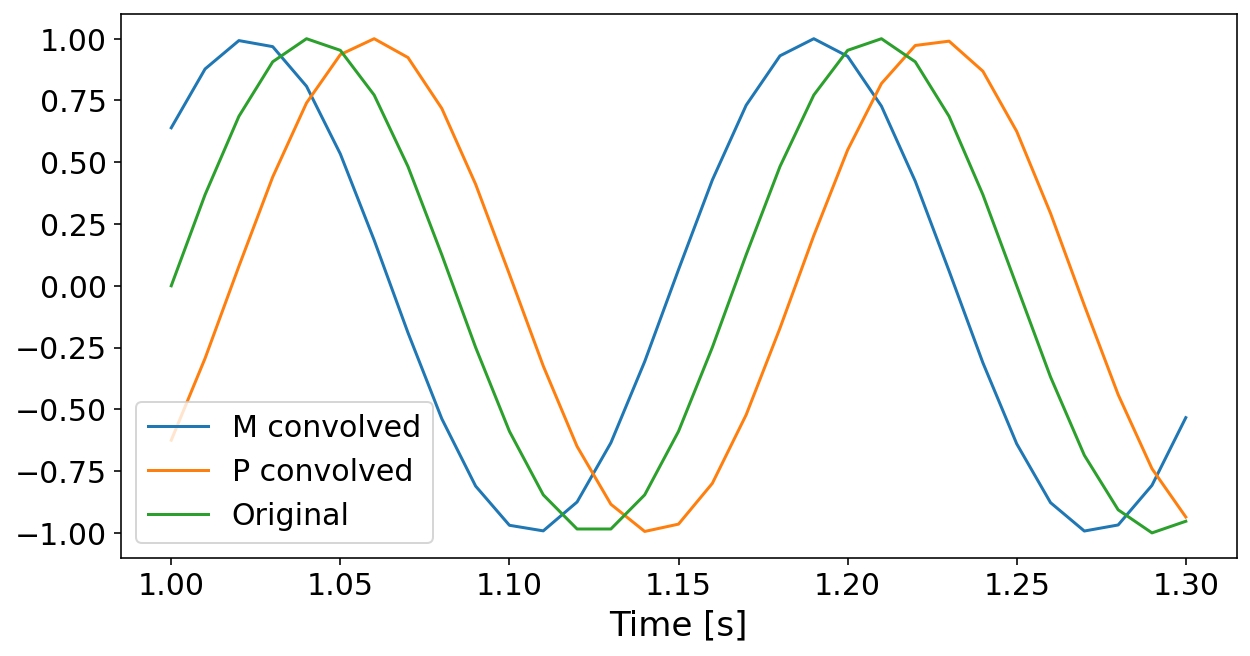

In [37]:
grating = create_grating(1., 0., np.pi/2)
grating_video = add_ramping(add_temporal_modulation(grating, omega_t=6.), 1.)
pixel_t = grating_video[0,0,:]
pixel_f = fftshift(fft(pixel_t))

conv_m_pixel_f = pixel_f * tkernel_m_f
conv_p_pixel_f = pixel_f * tkernel_p_f
conv_m_pixel_t = np.real(ifft(ifftshift(conv_m_pixel_f)))
conv_p_pixel_t = np.real(ifft(ifftshift(conv_p_pixel_f)))

def nz(s, zoom_range):
    """normalize and zoom"""
    return (s/s.max())[zoom_range]

time_z = np.arange(1., 1.3, dt)
zr = (time_z/dt).astype(int)

plt.figure(figsize=(10, 5))
plt.plot(time_z, nz(conv_m_pixel_t, zr), label='M convolved')
plt.plot(time_z, nz(conv_p_pixel_t, zr), label='P convolved')
plt.plot(time_z, nz(pixel_t, zr), label='Original')
plt.legend()
plt.xlabel('Time [s]')

plt.show()

We will now do the convolution using scipy's `filtfilt` function, since this avoids phase shifts. However, now the kernels have no effect at all. Also, `filtfilt` wants two different parameters for the filter, "numerator coefficient" and "denominator coefficient". I just used the same filter twice, which is probably the problem.

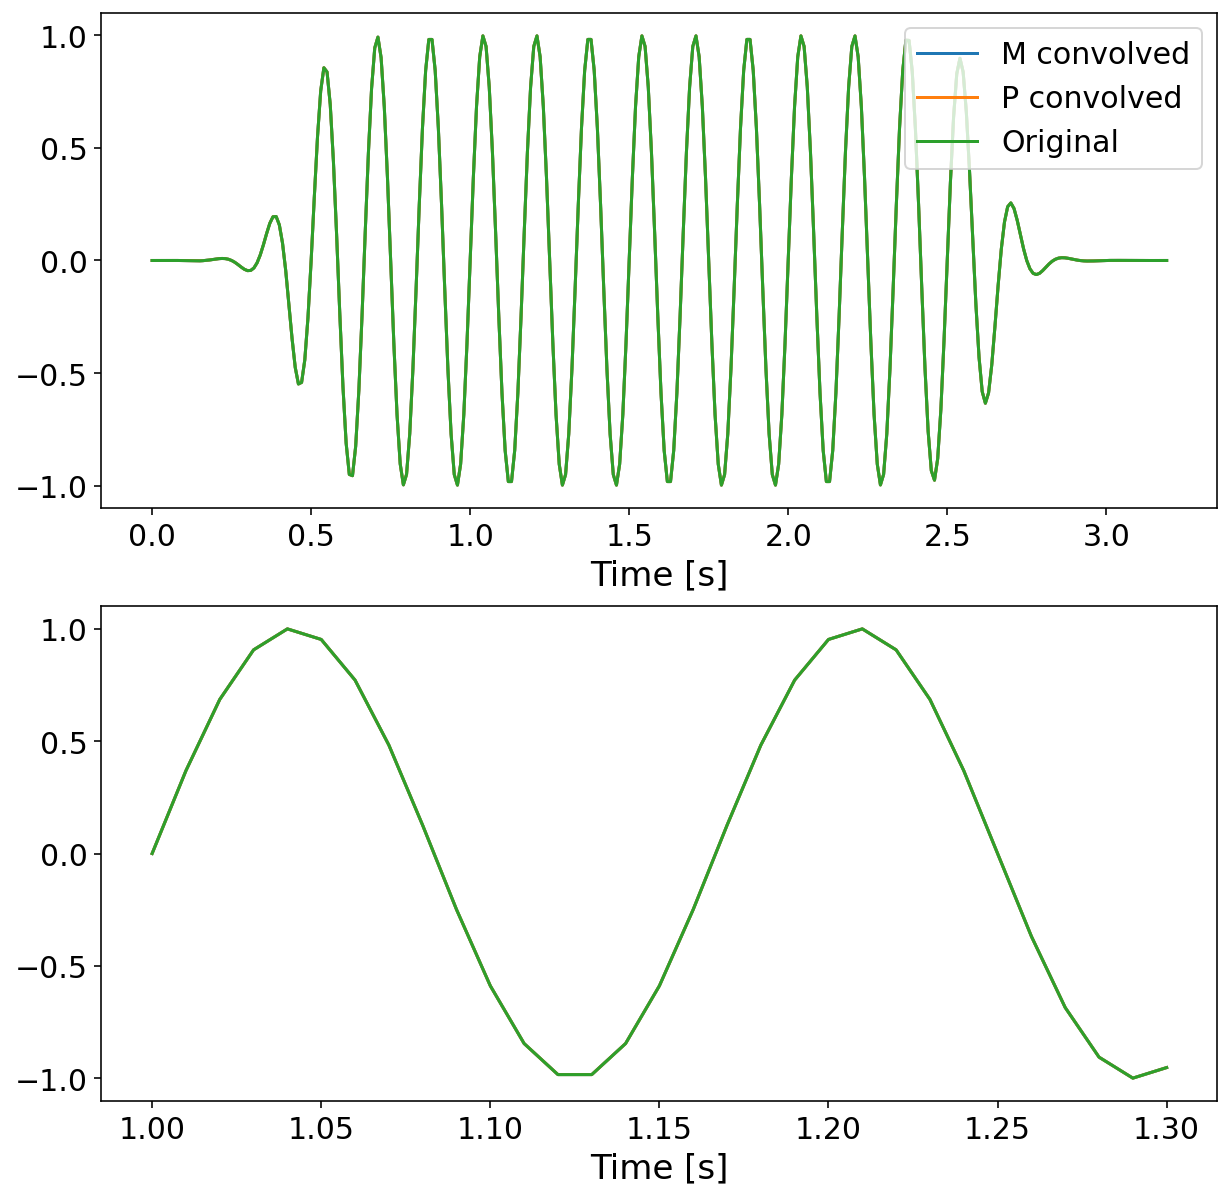

In [38]:
grating = create_grating(1., 0., np.pi/2)
grating_video = add_ramping(add_temporal_modulation(grating, omega_t=6.), 1.)
pixel_t = grating_video[0,0,:]

conv_m_pixel_t = filtfilt(tkernel_m_f2t[:15], tkernel_m_f2t[:15], pixel_t)
conv_p_pixel_t = filtfilt(tkernel_p_f2t[:15], tkernel_p_f2t[:15], pixel_t)

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(10, 10))

ax1.plot(time, conv_m_pixel_t, label='M convolved')
ax1.plot(time, conv_p_pixel_t, label='P convolved')
ax1.plot(time, pixel_t, label='Original')
ax1.set_xlabel('Time [s]')
ax1.legend()

def nz(s, zoom_range):
    """normalize and zoom"""
    return (s/s.max())[zoom_range]

time_z = np.arange(1., 1.3, dt)
zr = (time_z/dt).astype(int)
ax2.plot(time_z, nz(conv_m_pixel_t, zr))
ax2.plot(time_z, nz(conv_p_pixel_t, zr))
ax2.plot(time_z, nz(pixel_t, zr))
ax2.set_xlabel('Time [s]')

plt.show()

### Apply both kernels to a grating video

We apply both the spatial and the temporal kernel to one grating video. We visualize the convolved versions by showing a spatiotemporal slice, i.e. the middle row over time. 

The method used in the paper is different in that the kernels are never applied to the 2+1D grating video; instead the spatial dimensionality is reduced to 1 by radial averaging before the kernels are applied. This is done in the next section.

In [39]:
# create new grating video
grating = create_grating(1., 0., 0.)
grating_video_st = add_ramping(add_temporal_modulation(grating, omega_t=6.), 1.)
grating_video_f = fftshift(fftn(grating_video))

In [40]:
# convolve
conv_m_grating_video_f = grating_video_f * skernel_m_f[:,:,np.newaxis] * tkernel_m_f[np.newaxis,np.newaxis,:]
conv_m_grating_video_st = np.real(ifftn(ifftshift(conv_m_grating_video_f)))
conv_p_grating_video_f = grating_video_f * skernel_p_f[:,:,np.newaxis] * tkernel_p_f[np.newaxis,np.newaxis,:]
conv_p_grating_video_st = np.real(ifftn(ifftshift(conv_p_grating_video_f)))

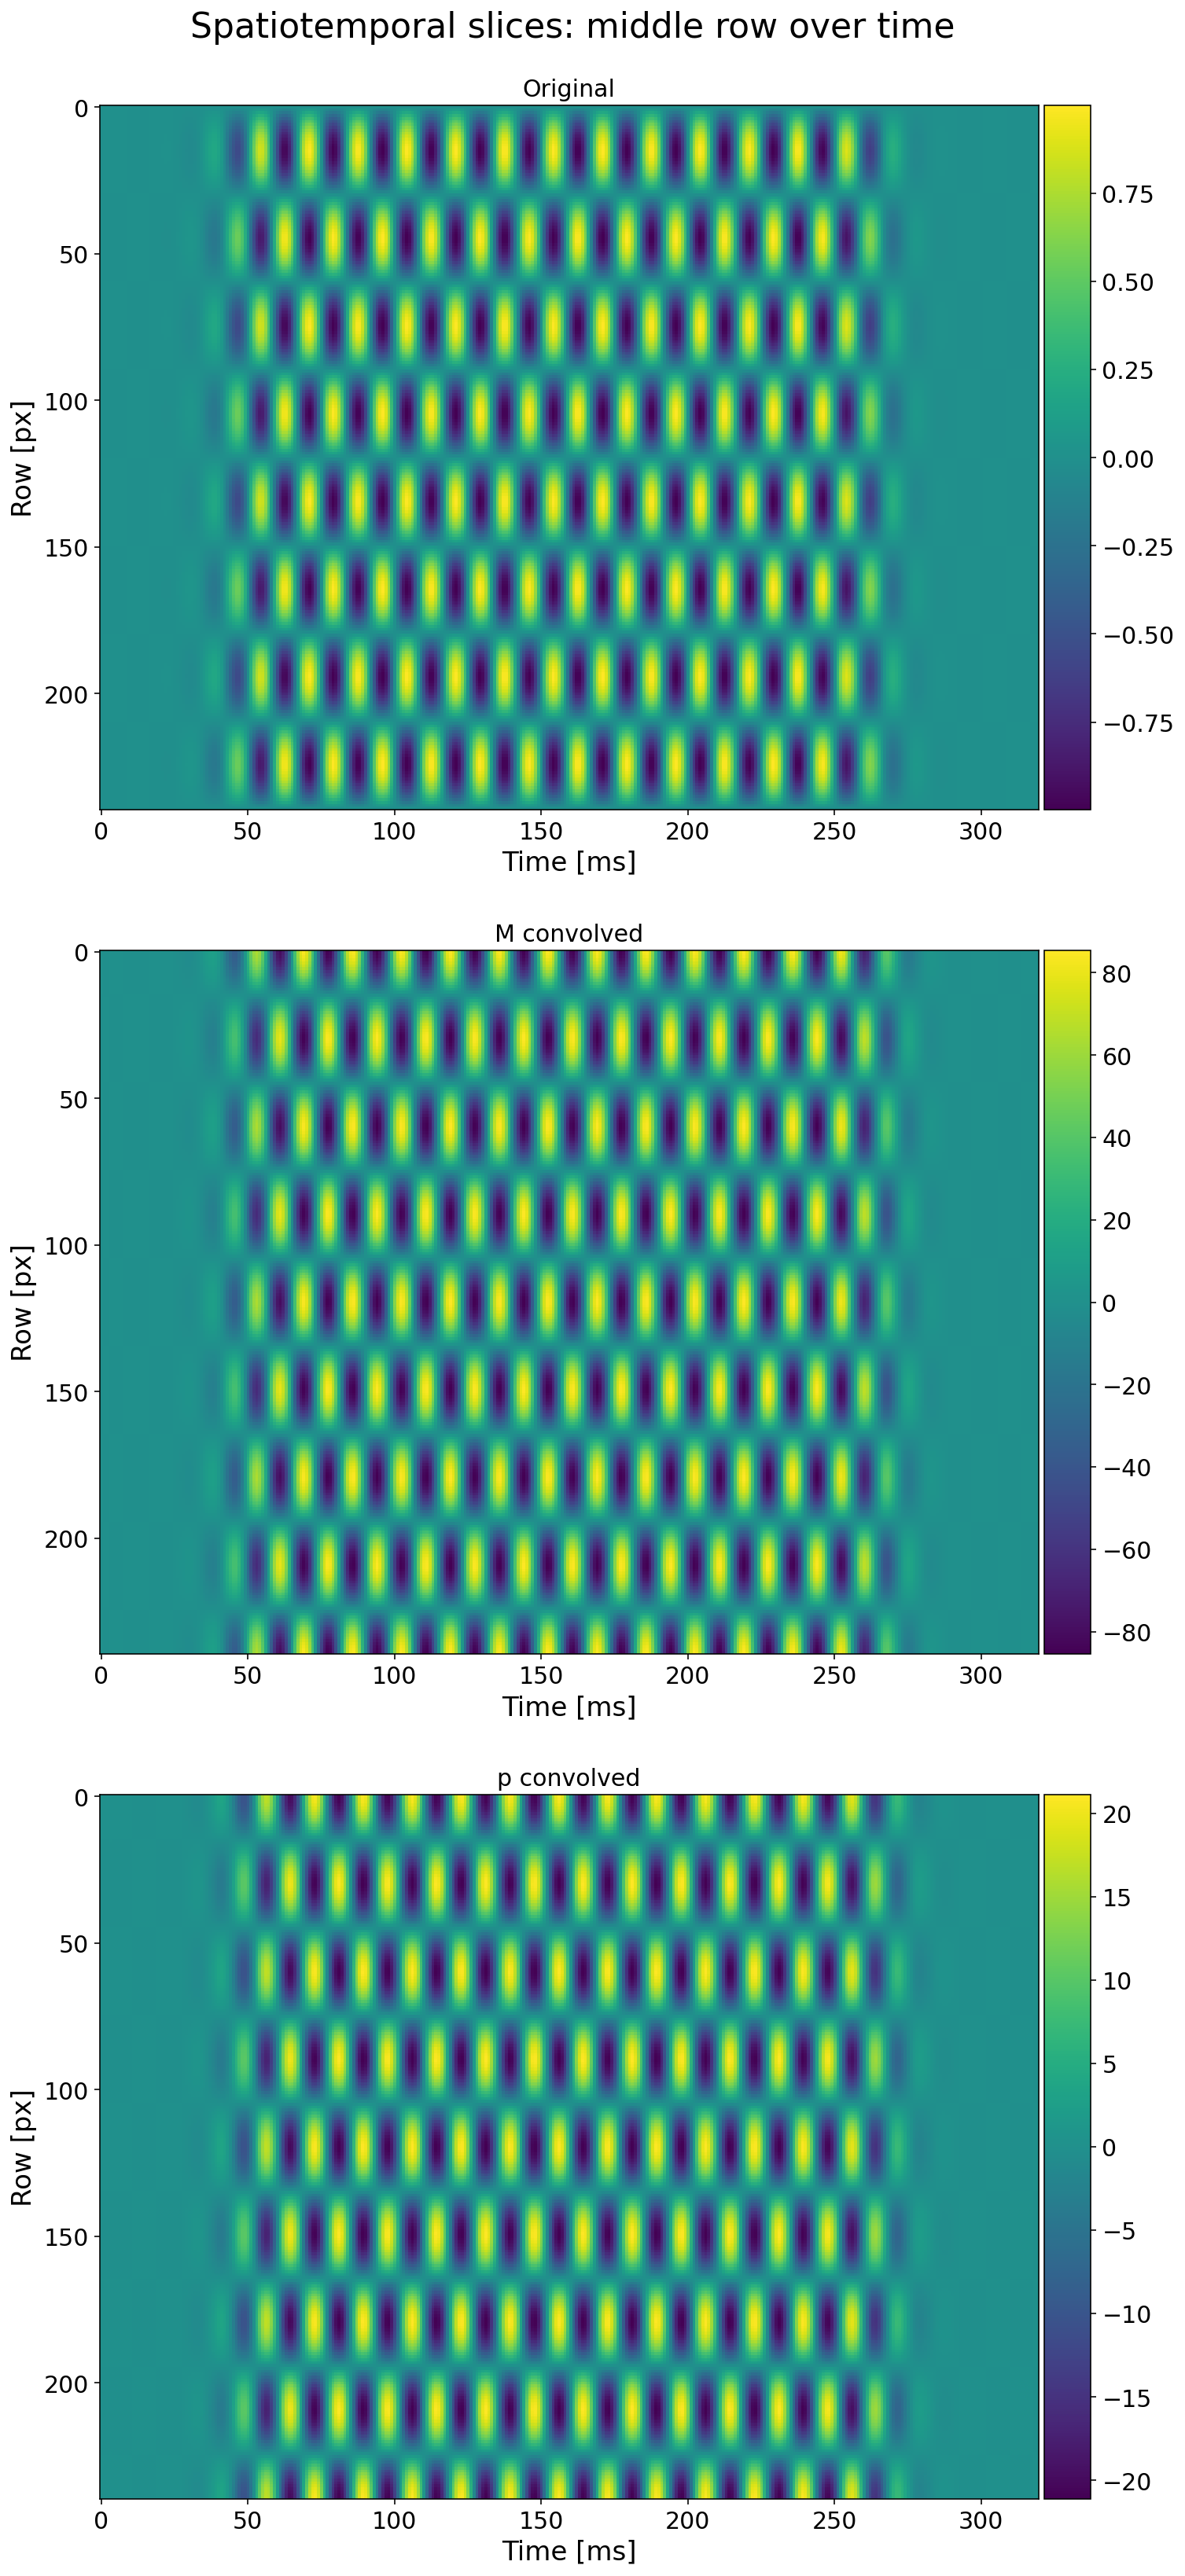

In [41]:
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(16,28))

plot_spatiotemporal_slice(grating_video_st, ax1, "Original")
plot_spatiotemporal_slice(conv_m_grating_video_st, ax2, "M convolved")
plot_spatiotemporal_slice(conv_p_grating_video_st, ax3, "p convolved")

plt.suptitle("Spatiotemporal slices: middle row over time", y=.91)

plt.show()

# Estimating contrast sensitivity

To better understand the paper's subsection "Estimating contrast sensitivity", we will go through these steps with only one example video (as opposed to the average accross different parameter values). Afterwards, there will be an interactive cell to explore the following steps for different grating video parameters. Finally in the next section, the cell responses will be aggregated using different strategies, since it is not all clear how that was done in the paper.

### Cell responses

First, the power spectrum is simply the square of the absolute values of the frequency domain representations (what I have referred to as the frequency spectra, though I'm not sure if that's accurate). Then we will do radial averaging of the spatial dimensions of the video.

In [42]:
# create new grating video
grating = create_grating(1., 0, 0.)
grating_video_st = add_ramping(add_temporal_modulation(grating, omega_t=6.), 1.)
grating_video_f = fftshift(fftn(grating_video_st))

In [43]:
# radially-averaged power spectrum of grating video
grating_video_squared = np.abs(grating_video_f)**2
grating_video_ps = np.array([radial_mean(grating_video_squared[:, :, i], f)[0] 
                             for i in range(grating_video_squared.shape[2])])

# sort temporal frequencies components by absolute temporal frequency (i.e. zero on bottom instead of center)
omega_abs = np.abs(omega)
omega_abs_idx = omega_abs.argsort()[::-1]

# spatial frequencies (after radial averaging)
radmean_freq = radial_mean(grating_video_squared[:, :, 0], f)[1]

In [44]:
def plot_spatiotemporal_power_spectrum(ps, ax, title="", logaxes=False):
    ps = ps[omega_abs_idx] # shifts temporal part to have zero-components on the bottom
    im = ax.imshow(np.log10(0.001 + ps), aspect='auto', 
                   extent=(radmean_freq.min(), radmean_freq.max(), omega_abs.min(), omega_abs.max()))
    ax.set_xlabel('Spatial frequency [c/d]')
    ax.set_ylabel('Temporal frequency [Hz]')
    ax.set_title(title)
    
    if logaxes:
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylim(.3, omega_abs.max())
        ax.set_xlim(.3, radmean_freq.max())

    add_colorbar(ax, im)

In [45]:
@interact(logaxes=False)
def _(logaxes):
    fig = plt.figure(figsize=(8, 6))
    plot_spatiotemporal_power_spectrum(grating_video_ps, fig.gca(), logaxes=logaxes)
    plt.suptitle('Spatiotemporal power spectrum of video')
    plt.show()

interactive(children=(Checkbox(value=False, description='logaxes'), Output()), _dom_classes=('widget-interact'…

<IPython.core.display.Javascript object>


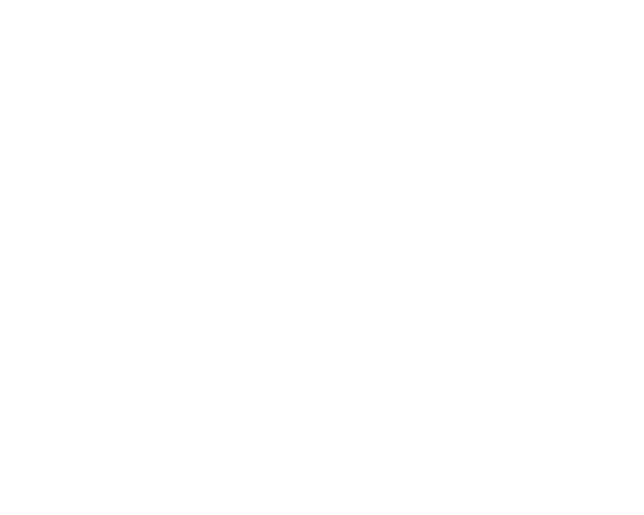

<IPython.core.display.Javascript object>


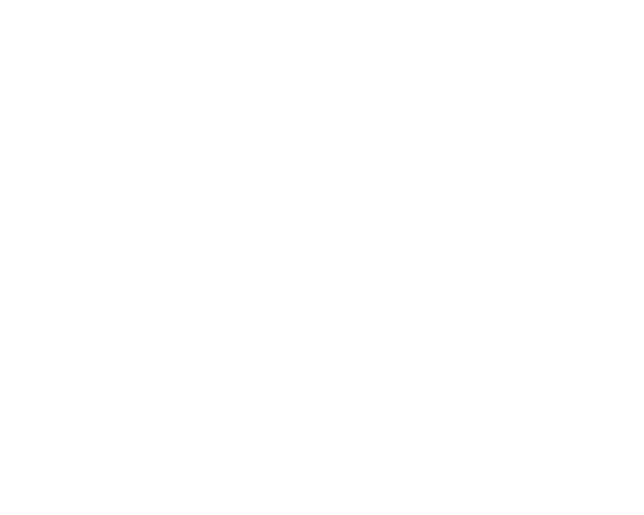

In [46]:
# just run this cell a couple of times until it works
# don't forget to switch matplotlib mode back using the cell below
%matplotlib notebook

fig = plt.figure(figsize=(10, 8))
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(radmean_freq, omega_abs)
Z = np.log10(0.001+grating_video_ps)
surf = ax.plot_surface(X, Y, Z, cmap='viridis')

In [47]:
%matplotlib inline

Now we will construct and apply the kernels to arrive at the spatiotemporal power spectrum of the neuronal responses:

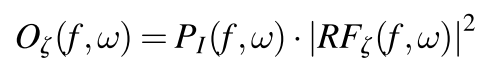

In [48]:
# radial averaging of spatial kernels
skernel_m_f_radmean, _ = radial_mean(skernel_m_f, f)
skernel_p_f_radmean, _ = radial_mean(skernel_p_f, f)

# combine kernels and square
transfer_func_m = ( skernel_m_f_radmean[np.newaxis, :] * tkernel_m_f[:, np.newaxis] )**2
transfer_func_p = ( skernel_p_f_radmean[np.newaxis, :] * tkernel_p_f[:, np.newaxis] )**2

In [49]:
# visualize transfer function
@interact(logaxes=False)
def _(logaxes):
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    plt.suptitle('Power spectra of transfer functions (i.e. combined kernels)')

    plot_spatiotemporal_power_spectrum(np.abs(transfer_func_m), ax=ax1, title='M cell', logaxes=logaxes)
    plot_spatiotemporal_power_spectrum(np.abs(transfer_func_p), ax=ax2, title='P cell', logaxes=logaxes)
    
    vmax = np.log10(max(np.max(np.abs(transfer_func_m)), np.max(np.abs(transfer_func_p))))
    ax1.get_images()[0].set_clim(-1, vmax)
    ax2.get_images()[0].set_clim(-1, vmax)
    
    plt.show()

interactive(children=(Checkbox(value=False, description='logaxes'), Output()), _dom_classes=('widget-interact'…

In [50]:
# apply the kernels
conv_m_grating_video_ps = np.abs(grating_video_ps * transfer_func_m)
conv_p_grating_video_ps = np.abs(grating_video_ps * transfer_func_p)

In [51]:
@interact(logaxes=False)
def _(logaxes):
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    plt.suptitle('Power spectrum of cell responses')

    plot_spatiotemporal_power_spectrum(conv_m_grating_video_ps, ax=ax1, title='M cell', logaxes=logaxes)
    plot_spatiotemporal_power_spectrum(conv_p_grating_video_ps, ax=ax2, title='P cell', logaxes=logaxes)

    plt.show()

interactive(children=(Checkbox(value=False, description='logaxes'), Output()), _dom_classes=('widget-interact'…

Finally, we evaluate the cell's response by integrating over time (discarding frequency components under 0.63 Hz, as described in the paper):

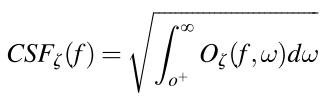

In [52]:
# discard frequency components < 0.6 Hz from the kernels
conv_m_grating_video_ps[np.abs(omega)<0.6, :] = 0
conv_p_grating_video_ps[np.abs(omega)<0.6, :] = 0

# numerically integrate over time and take squareroot
CR_M = np.sqrt(conv_m_grating_video_ps.sum(axis=0))
CR_P = np.sqrt(conv_p_grating_video_ps.sum(axis=0))

# I chose to call these variables cr (though they represent the final CSF formula above), because at this
# stage, they only represent the cell response, which get aggregated to form the CSF in the next section

In [53]:
def plot_all_cr(CR_M, CR_P, x=radmean_freq, title="", axes=None):
    """
    Reproducing figure 3 from the paper

    parameters
    ------------
    CR_M, CR_P - response vectors
    x - frequency vector (default radmean_freq, i.e. the frequencies from after radial averaging)
    title - of plot
    axes - array of three matplotlib axes on which to plot graphs (axes=None creates a new figure)

    returns
    ---------
    CR_M - cell response spectrum of M cell
    CR_P - cell response spectrum of P cell
    """
    # linear combination
    A = 1
    lambda_const = 0.57
    linear_combination = A * (lambda_const * CR_M + (1 - lambda_const) * CR_P)
    
    # plotting
    if axes is None:
        fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(18, 6), sharey='row')
        fig.suptitle(title)
    else:
        [ax1, ax2, ax3] = axes

    ax1.set_title('Linear combination')
    ax1.plot(x, linear_combination, color='C2')
    ax2.set_title('M cell')
    ax2.plot(x, CR_M, color='C0')
    ax3.set_title('P cell')
    ax3.plot(x, CR_P, color='C1')

    for ax in [ax1, ax2, ax3]:
        ax.set_xlabel('Spatial frequency [c/d]')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.xaxis.set_major_formatter(ScalarFormatter())
        ax.xaxis.set_ticks([1,3,10,30])
        ax.set_ylim(0.3, None) # the graphs from the paper are cut off at 0.3, I think
        
    if axes is None:
        plt.show()

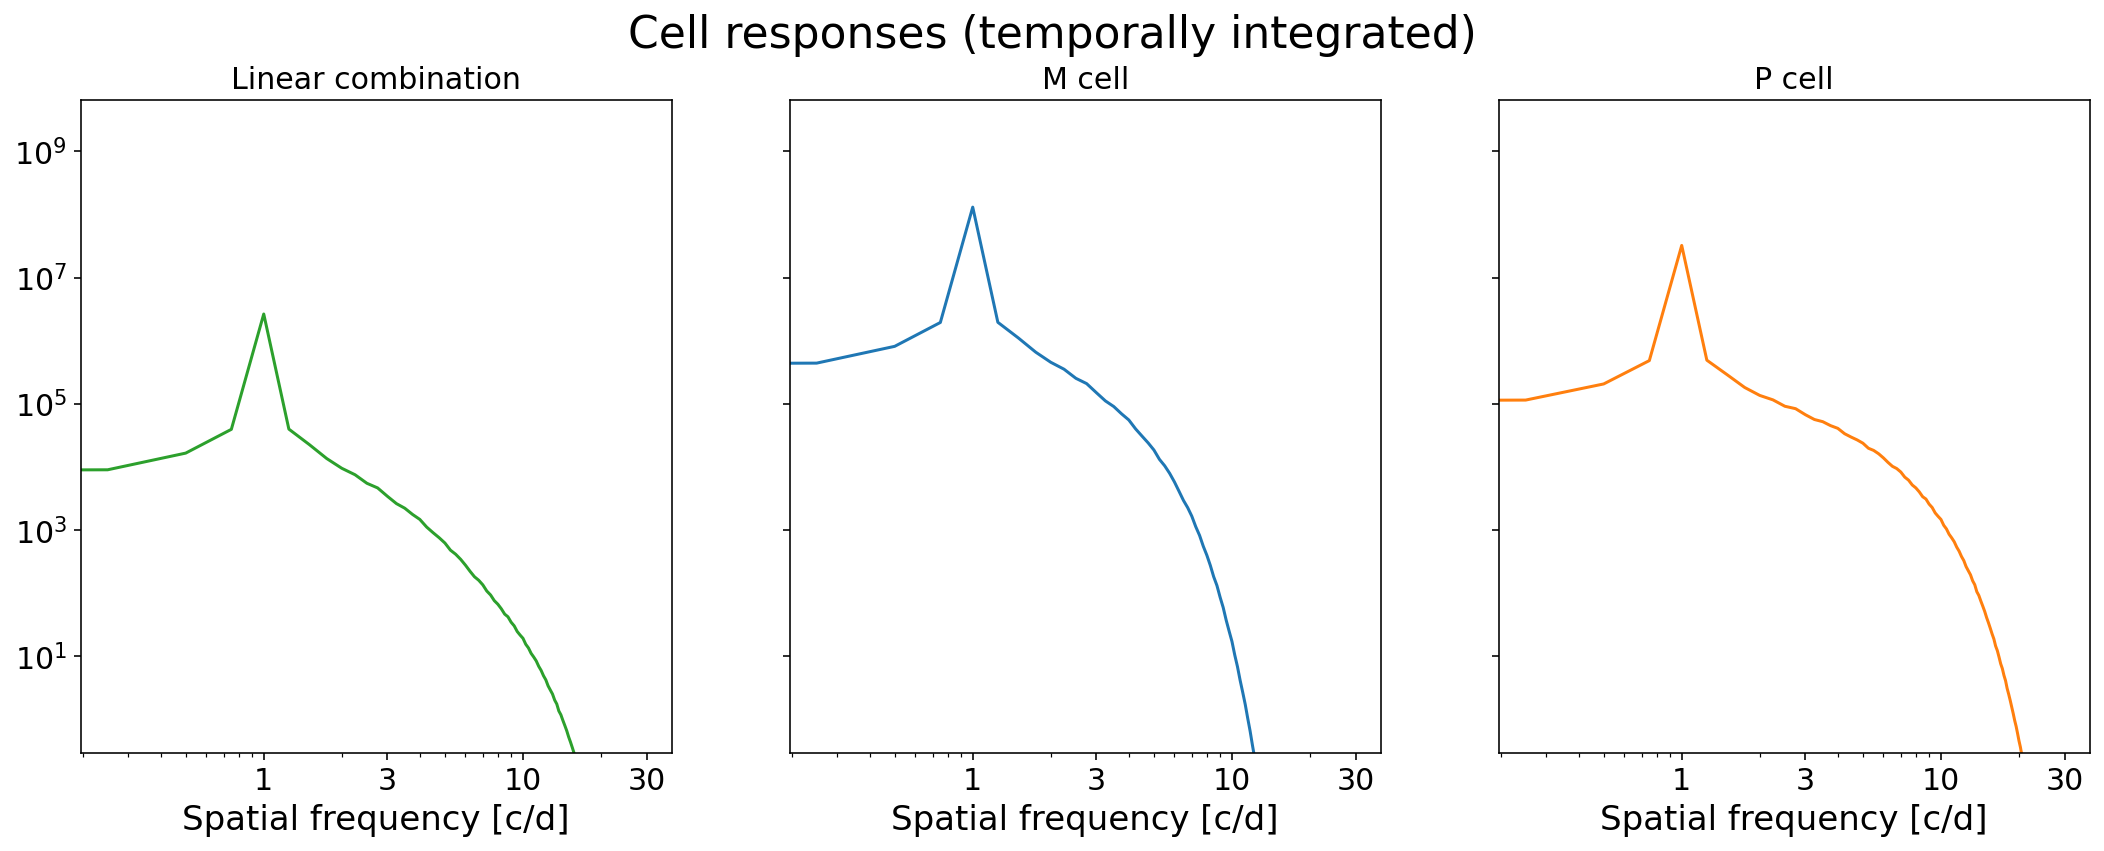

In [54]:
plot_all_cr(CR_M, CR_P, title="Cell responses (temporally integrated)")

("Prussian Hat Function" https://upload.wikimedia.org/wikipedia/commons/8/8d/Bismarck_pickelhaube.jpg)

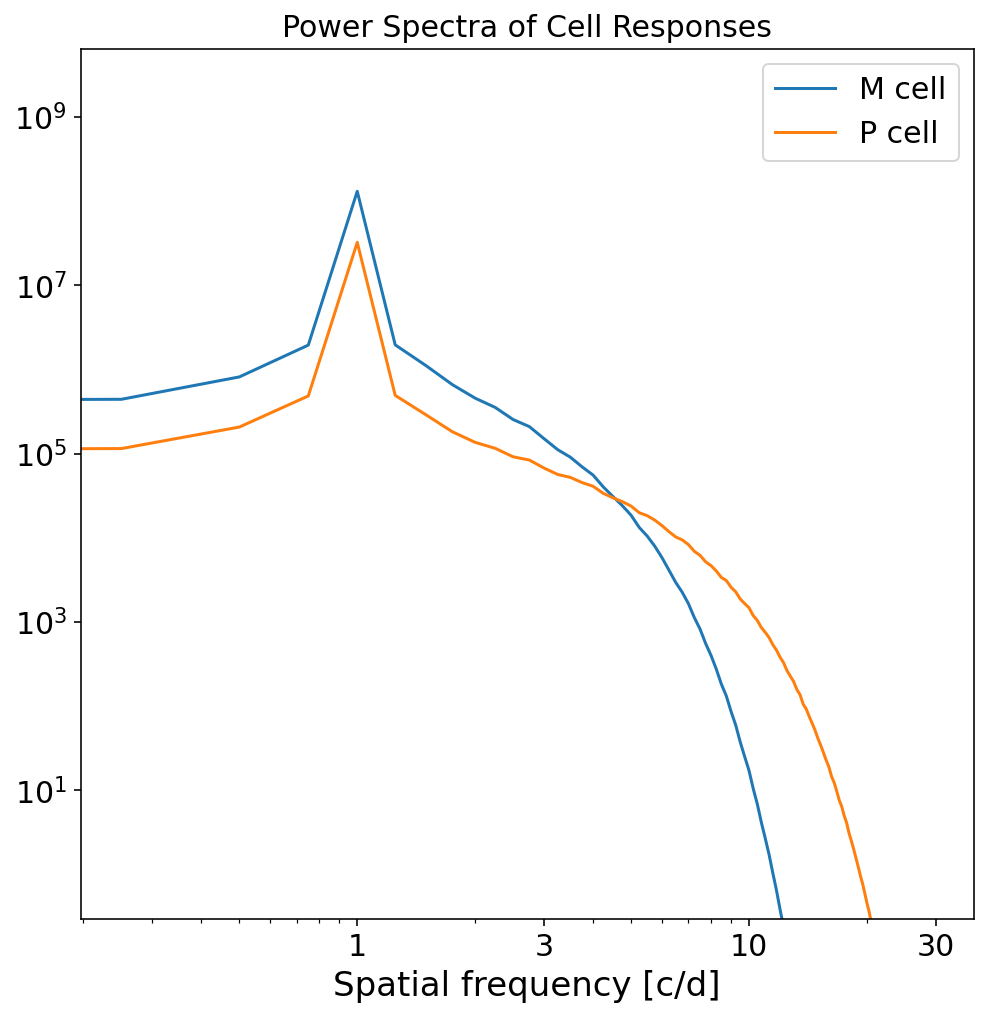

In [55]:
# figure for poster
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.plot(radmean_freq, CR_M, color='C0', label='M cell')
ax.plot(radmean_freq, CR_P, color='C1', label='P cell')
ax.set_xlabel('Spatial frequency [c/d]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_ticks([1,3,10,30])
ax.set_ylim(0.3, None) # the graphs from the paper are cut off at 0.3, I think
ax.set_title('Power Spectra of Cell Responses')
plt.legend()
plt.show()

### Cell responses for different parameters

The steps from above are copied here, in a more compact way, in order to play around with different parameters.

In [56]:
# describe params
@interact_manual(f_s=(1, 30), omega_t=(0, 50), alpha=(0, np.pi, np.pi/6), gabor=False, logaxes=False)
def _(f_s=3., omega_t=6., alpha=0., gabor=False, logaxes=False):
    # create new grating video
    grating = create_grating(f_s, alpha, 0.)
    if gabor:
        grating = add_spatial_gaussian(grating, sigma=0.25)
    grating_video_st = add_ramping(add_temporal_modulation(grating, omega_t), 1.)
    grating_video_f = fftshift(fftn(grating_video_st))
    
    # radially-averaged power spectrum of grating video
    grating_video_squared = np.abs(grating_video_f)**2
    grating_video_ps = np.array([radial_mean(grating_video_squared[:, :, i], f)[0] 
                                 for i in range(grating_video_squared.shape[2])])
    
    # apply the kernels
    conv_m_grating_video_ps = np.abs(grating_video_ps * transfer_func_m)
    conv_p_grating_video_ps = np.abs(grating_video_ps * transfer_func_p)
    
    # discard frequency components < 0.6 Hz from the kernels
    conv_m_grating_video_ps[np.abs(omega)<0.6, :] = 0
    conv_p_grating_video_ps[np.abs(omega)<0.6, :] = 0

    # numerically integrate over time and take squareroot
    CR_M = np.sqrt(conv_m_grating_video_ps.sum(axis=0))
    CR_P = np.sqrt(conv_p_grating_video_ps.sum(axis=0))
    
    # plotting
    fig, [[ax11, ax12, ax13], [ax21, ax22, ax23], [ax31, ax32, ax33]] = plt.subplots(3, 3, figsize=(16, 16))
    
    ax11.set_visible(False)
    plot_spatiotemporal_power_spectrum(np.abs(transfer_func_m), ax12, 'M transfer function', logaxes)
    plot_spatiotemporal_power_spectrum(np.abs(transfer_func_p), ax13, 'P transfer function', logaxes)
    
    plot_spatiotemporal_power_spectrum(grating_video_ps, ax21, 'Original spectrum', logaxes)
    plot_spatiotemporal_power_spectrum(conv_m_grating_video_ps, ax22, 'M convolved spectrum', logaxes)
    plot_spatiotemporal_power_spectrum(conv_p_grating_video_ps, ax23, 'P convelved spectrum', logaxes)
    
    plot_all_cr(CR_M, CR_P, axes=[ax31, ax32, ax33])
    
    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=3, description='f_s', max=30, min=1), IntSlider(value=6, description='om…

# Constructing the CSFs

Now we will try to estimate the CSF by computing the cell responses for a multitude of spatial frequencies, orientations, and phases. Since we are not sure how to combine these different responses, we try three strategies: 

1. __Cell Responses For Averaged Power Spectra__: average the power spectra over spatial frequencies, orientations, and phases, and then compute the cell responses for that power spectrum;
<br>

2. __Averaged Cell Responses__: average the power spectra over orientations and phases only, <br>then for each spatial frequency $f_s$ compute the cell response $CR_{f_s}$, <br>and then average those cell responses: $CSF(f) = \frac{1}{n}\sum CR_{f_s}(f)$;
<br>

3. __Point-wise Response__: average the power spectra over orientations and phases only, <br>then for each spatial frequency $f_s$ compute the cell response $CR_{f_s}$, <br>then take the absolute value of the cell response at that frequency $r_{f_s} = CR_{f_s}(f_s)$, <br>and then construct the final CSF from those responses: $CSF(f)=r_f$.
<br>

On top of the uncertainty about the aggregation strategy, there is uncertainty about:
- the spatial kernels, since we coulnd't get the implementation sent to us to line up with the formula from the paper
- the temporal kernels, since we couldn't reproduce the graph showing their spectra exactly, and got closer to reproducing only by using a `rho` value different from the one given in the paper
- why the absolute CSF values we arrive at (max≈10^7) are so much larger than in the paper (max≈10^1), or whether they have been normalized

Hence, we executed all three strategies for different versions of the kernel:
- spatial kernel: either frequency domain or spatial domain implementation
- temporal domain: either `rho=1` (as up to now in this notebook) or `rho=1/1.6` (as in the paper)

In [57]:
# again, this function is the same as above, but even more compact
def compute_cell_responses(video_ps, transfer_func_m, transfer_func_p):
    """
    Compute the response spectrum (of each cell type) for a given video.

    parameters
    ------------
    video_ps - spatiotemporal powerspectrum
    transfer_func_m, transfer_func_p - combination of spatial and temporal kernels

    returns
    ---------
    CR_M - cell response spectrum of M cell
    CR_P - cell response spectrum of P cell
    """
    P_I = np.array([radial_mean(video_ps[:, :, i], f)[0] for i in range(video_ps.shape[2])])

    # apply the kernels
    O_M = np.abs(P_I * transfer_func_m)
    O_P = np.abs(P_I * transfer_func_p)

    # discard frequency components < 0.6 Hz from the kernels
    O_M[np.abs(omega)<0.6, :] = 0
    O_P[np.abs(omega)<0.6, :] = 0

    # numerically integrate over time and take squareroot
    # (in the paper, this is the formula for CSF_zeta,
    # but that would only be accurate for the above strategy 1, so I opted to rename it)
    CR_M = np.sqrt(O_M.sum(axis=0))
    CR_P = np.sqrt(O_P.sum(axis=0))

    return CR_M, CR_P

In [58]:
# Create grating videos with different spatial frequencies, orientations, phases.

# Temporal modulation
omega_t = 6.
ramp_time = 1.

# Spatial frequency
n_freq = 100
freq = np.linspace(0.1, 30, n_freq)

# Orientation
n_alpha = 8
alpha_s = np.linspace(0, 2*np.pi, n_alpha)

# Phase
n_phi = 1
phi_s = np.linspace(0, 2*np.pi, n_phi)


# example video just to get some parameters
grating = create_grating(0, 0, 0)
radmean_freq = radial_mean(grating, f)[1]
cell_response_size = len(radmean_freq)

In [59]:
def construct_csf(transfer_func_m, transfer_func_p):
    """
    Compute cell responses for inputs that vary in spatial frequency, orientation, and phase, 
    then combine them into one CSF (per cell type) using different strategies (see above).
    """
    # average-aggregators
    # strategy 1
    avg_video_ps = np.zeros((n_size, n_size, n_time))
    avg_video_ps_counter = 0
    # strategy 2
    avg_CR_M = np.zeros(cell_response_size)
    avg_CR_P = np.zeros(cell_response_size)
    avg_CR_counter = 0
    #strategy 3
    pointwise_CSF_M = np.zeros(n_freq)
    pointwise_CSF_P = np.zeros(n_freq)

    # Loop over all frequencies, phases and orientations:
    for h in range(n_freq):
        avg_video_ps_per_f = np.zeros((n_size, n_size, n_time))
        avg_video_ps_per_f_counter = 0

        for i in range(n_alpha):
            for j in range(n_phi):
                # Create grating
                grating = create_grating(freq[h], alpha_s[i], phi_s[j])

                # Creatine video with grating that is modulated over time (without eye movements)
                grating_video = add_temporal_modulation(grating, omega_t)

                # n-dimensional fft
                grating_video_fft = fftshift(fftn(grating_video))

                # Calculate power
                grating_video_ps = np.abs(grating_video_fft)**2

                # aggregate
                avg_video_ps += grating_video_ps
                avg_video_ps_counter += 1

                avg_video_ps_per_f += grating_video_ps
                avg_video_ps_per_f_counter += 1

        # Calculate cell responses to orientation-phase-avergae for a single spatial frequency
        avg_video_ps_per_f /= avg_video_ps_per_f_counter
        CR_M, CR_P = compute_cell_responses(avg_video_ps_per_f, transfer_func_m, transfer_func_p)
        
        # set pointwise value: find index of response value for current spatial frequency
        idx = (np.abs(radmean_freq - freq[h])).argmin()
        pointwise_CSF_M[h] = CR_M[idx]
        pointwise_CSF_P[h] = CR_P[idx]

        # aggregate
        avg_CR_M += CR_M
        avg_CR_P += CR_P
        avg_CR_counter += 1


    avg_CR_M /= avg_CR_counter
    avg_CR_P /= avg_CR_counter

    avg_video_ps /= avg_video_ps_counter
    CSF_M_of_avg, CSF_P_of_avg = compute_cell_responses(avg_video_ps, transfer_func_m, transfer_func_p)
    
    return (CSF_M_of_avg, CSF_P_of_avg), (avg_CR_M, avg_CR_P), (pointwise_CSF_M, pointwise_CSF_P)

### Compute and plot (this can take a while)
#### Kernels used for transfer function
- spatial kernels: frequency domain implementation
- temporal kernels: `rho=1/1.6` from paper

In [60]:
# this variable exists so you can run all cells without running the long computation
run_long_computation = True

In [61]:
# construct transfer functions and compute the CSFs

# radial averaging of spatial kernels
skernel_m_f_radmean, _ = radial_mean(skernel_m_f, f)
skernel_p_f_radmean, _ = radial_mean(skernel_p_f, f)

# temporal kernel with rho=1/1.6
tkernel_m_f = get_tkernel_m_f(omega, 1./1.6)
tkernel_p_f = get_tkernel_p_f(omega, 1./1.6)

# combine kernels and square
transfer_func_m = ( skernel_m_f_radmean[np.newaxis, :] * tkernel_m_f[:, np.newaxis] )**2
transfer_func_p = ( skernel_p_f_radmean[np.newaxis, :] * tkernel_p_f[:, np.newaxis] )**2

# compute CSFs given these kernels
if run_long_computation:
    (CSF_M_of_avg, CSF_P_of_avg), (avg_CR_M, avg_CR_P), (pointwise_CSF_M, pointwise_CSF_P) = \
        construct_csf(transfer_func_m, transfer_func_p)

In [62]:
# visualize transfer function
@interact(logaxes=False)
def _(logaxes):
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    plt.suptitle('Power spectrum of transfer functions (i.e. combined kernels)')

    plot_spatiotemporal_power_spectrum(np.abs(transfer_func_m), ax1, 'M cell', logaxes)
    plot_spatiotemporal_power_spectrum(np.abs(transfer_func_p), ax2, 'P cell', logaxes)

    plt.show()

interactive(children=(Checkbox(value=False, description='logaxes'), Output()), _dom_classes=('widget-interact'…

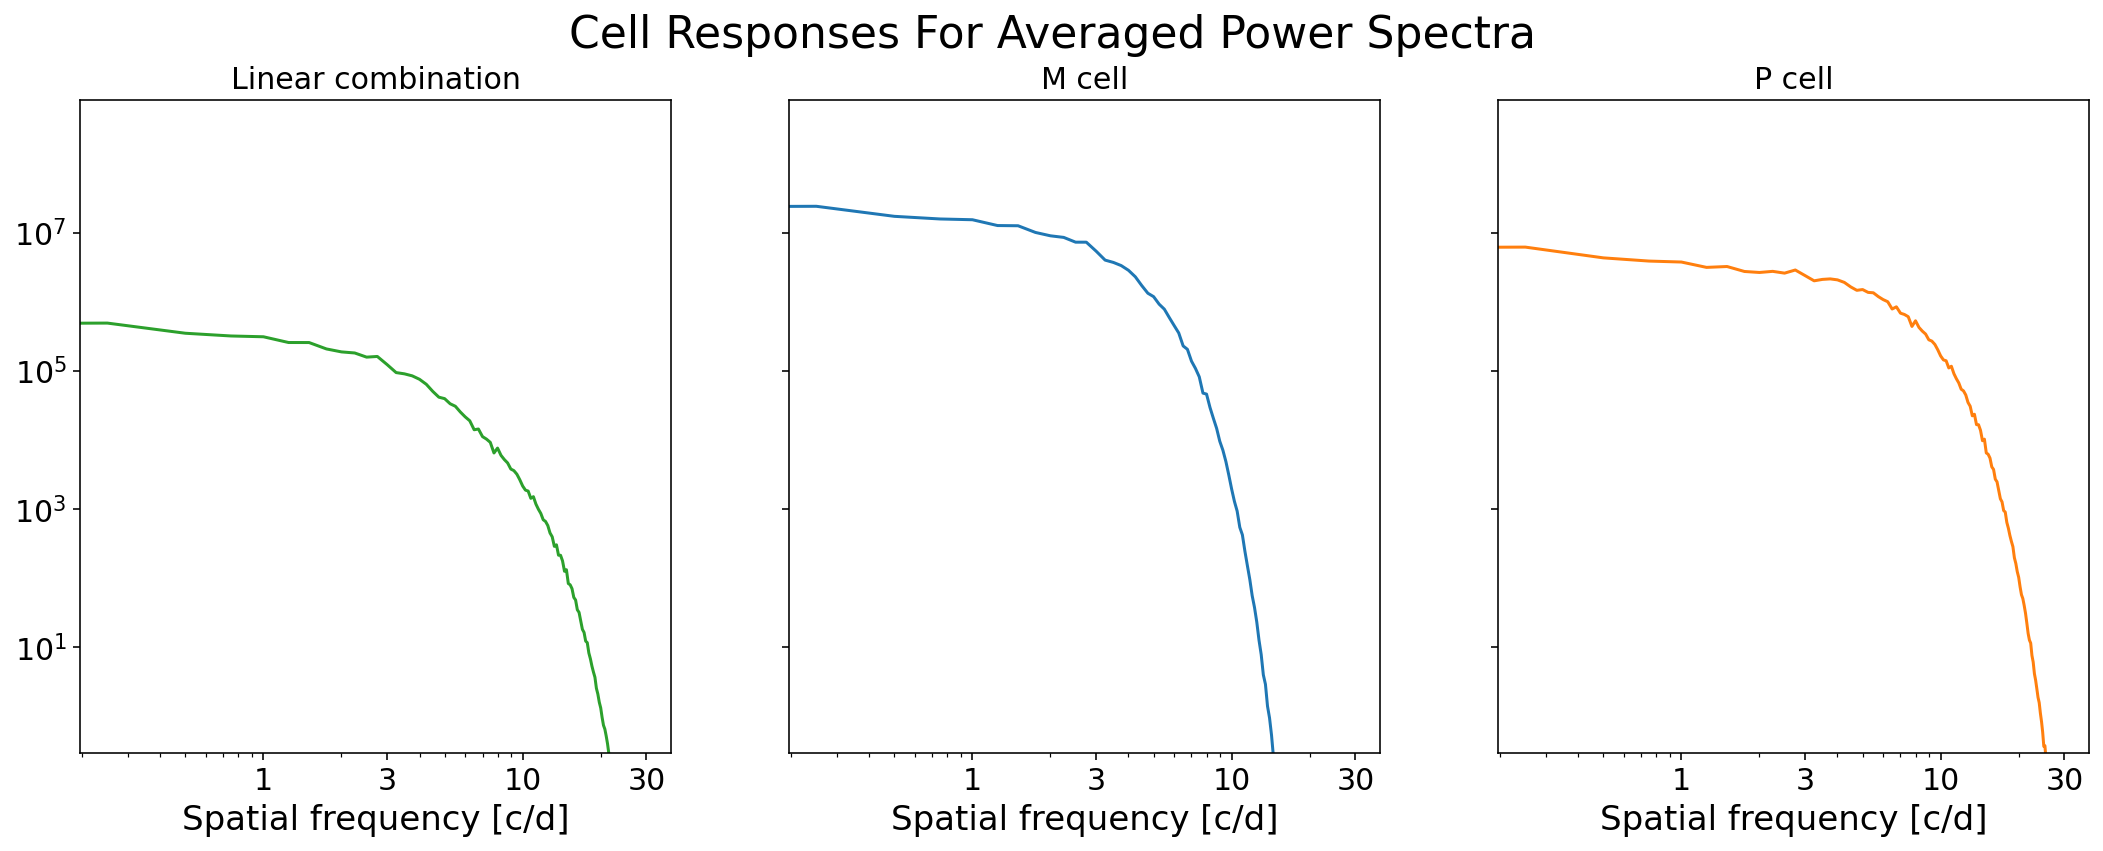

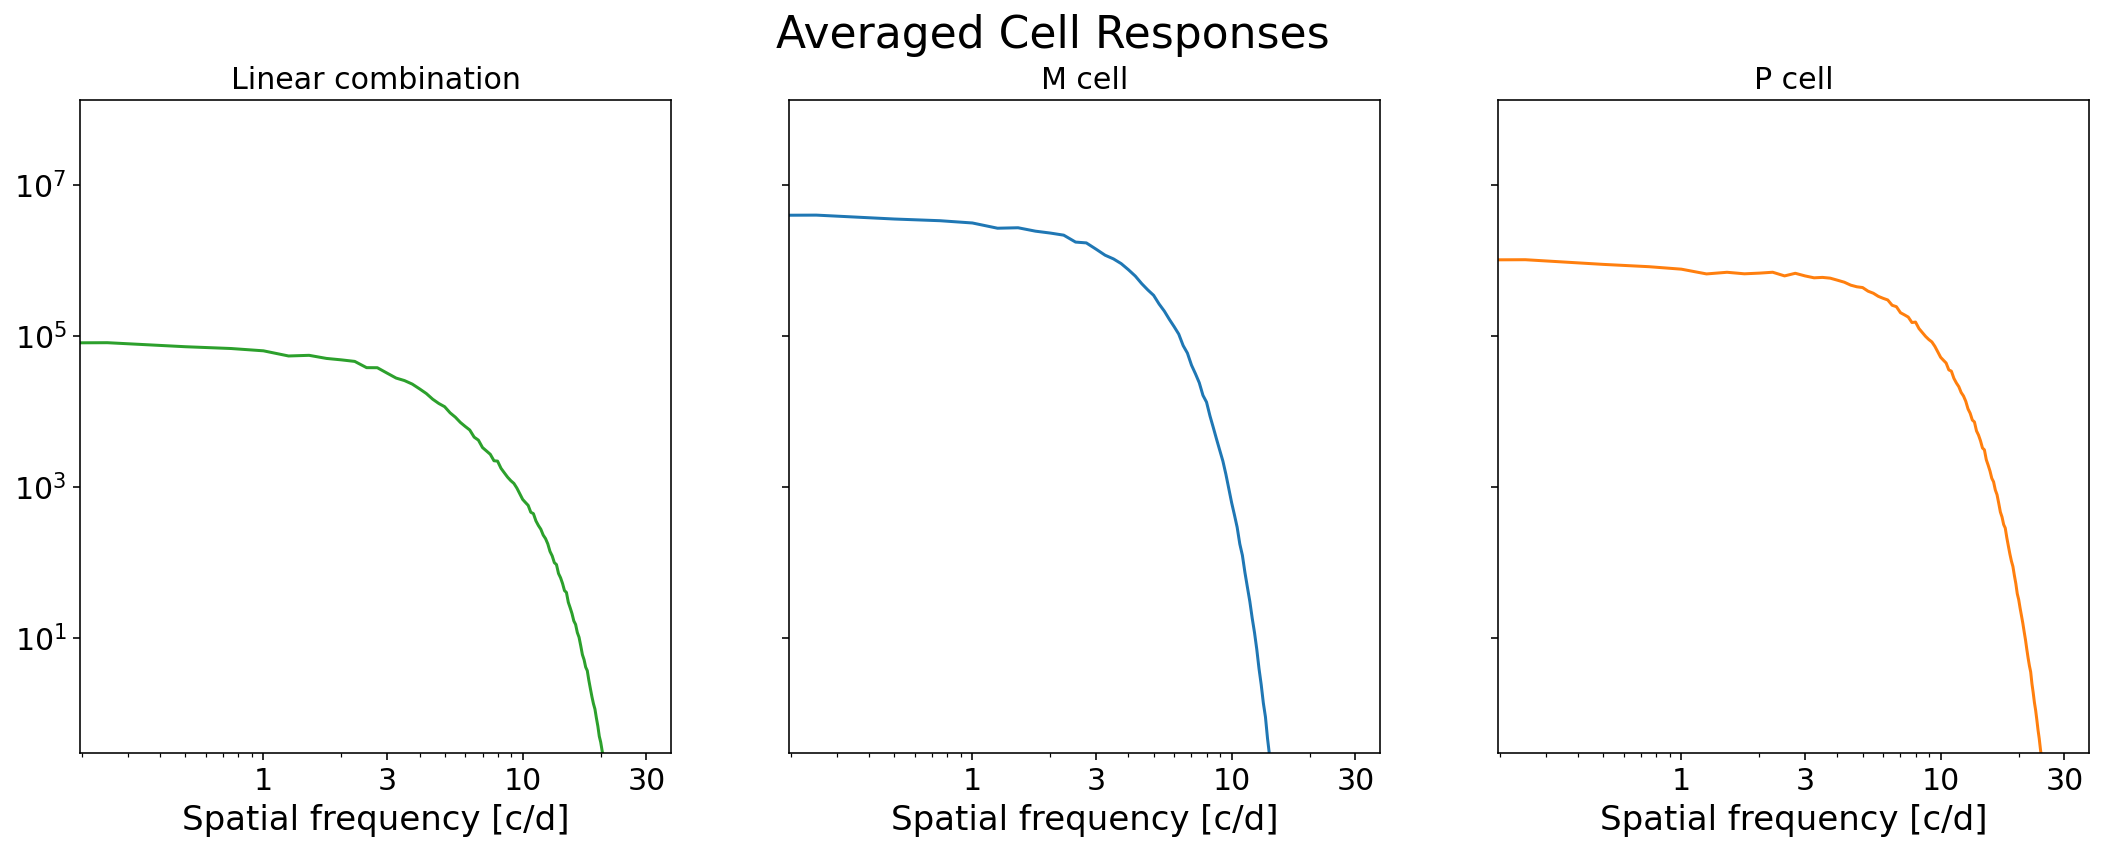

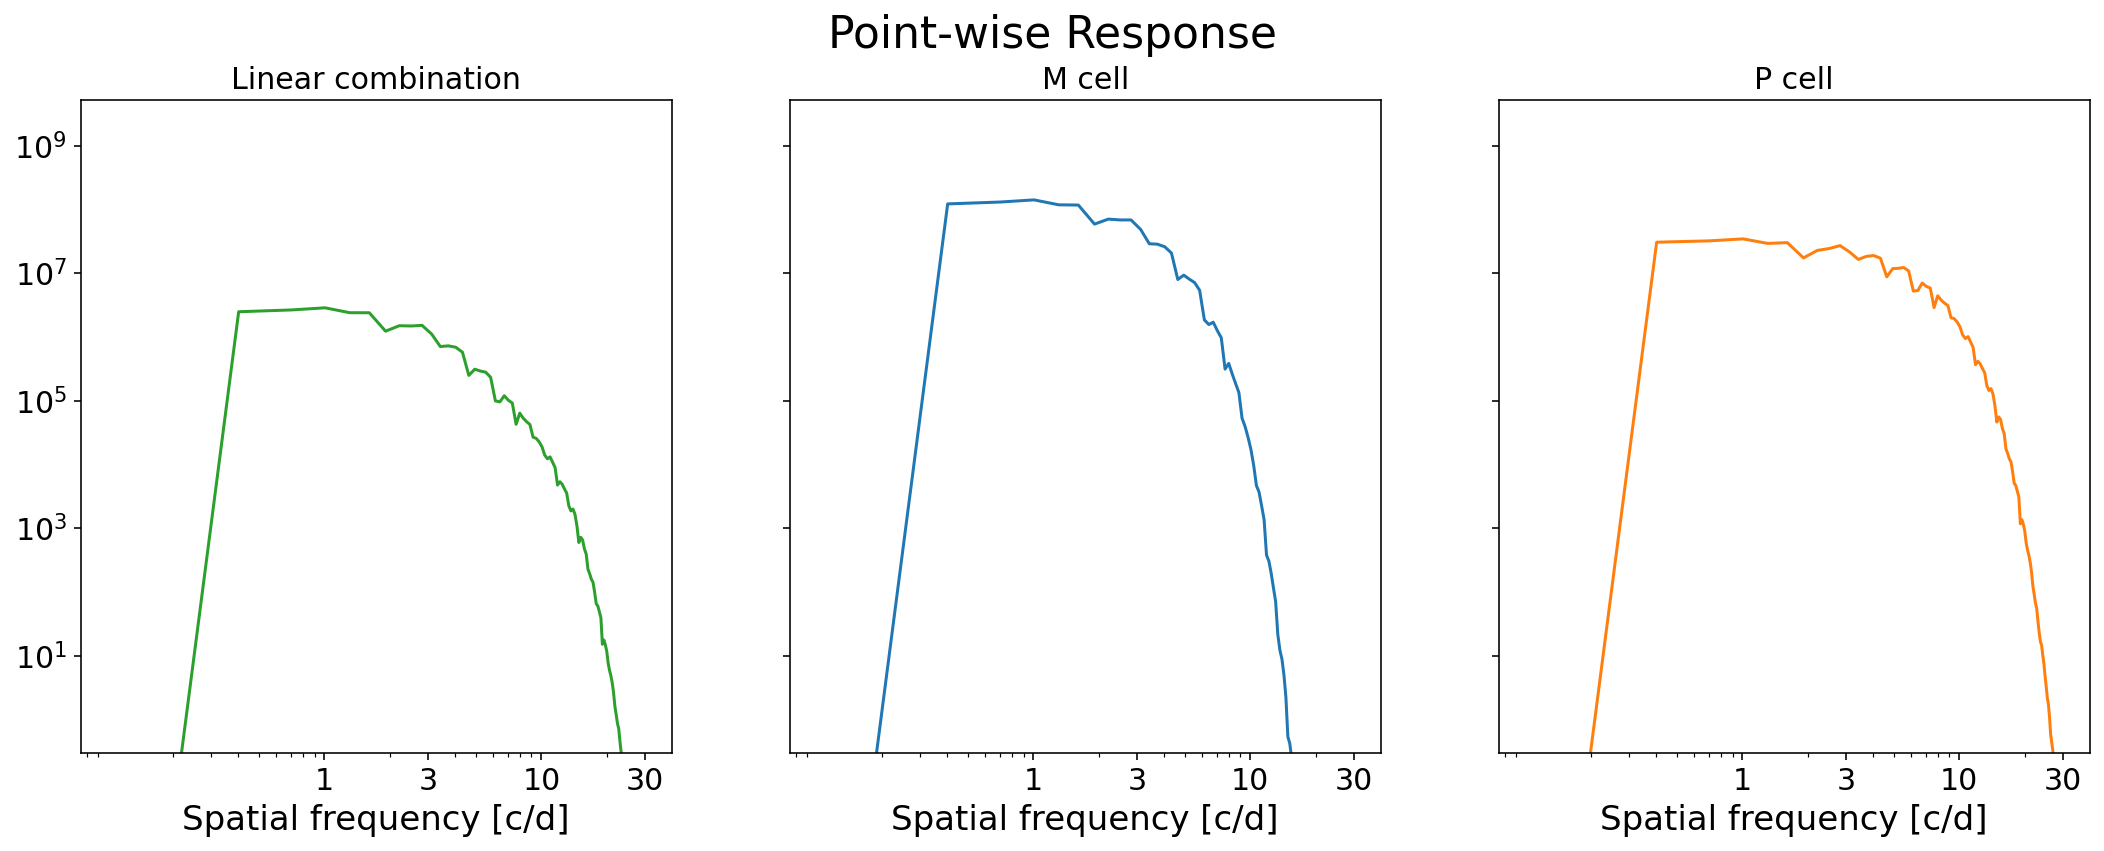

In [63]:
# plot the resulting CSFs

plot_all_cr(CSF_M_of_avg, CSF_P_of_avg, title='Cell Responses For Averaged Power Spectra');plt.show()
plot_all_cr(avg_CR_M, avg_CR_P, title='Averaged Cell Responses');plt.show()
plot_all_cr(pointwise_CSF_M, pointwise_CSF_P, x=freq, title='Point-wise Response');plt.show()

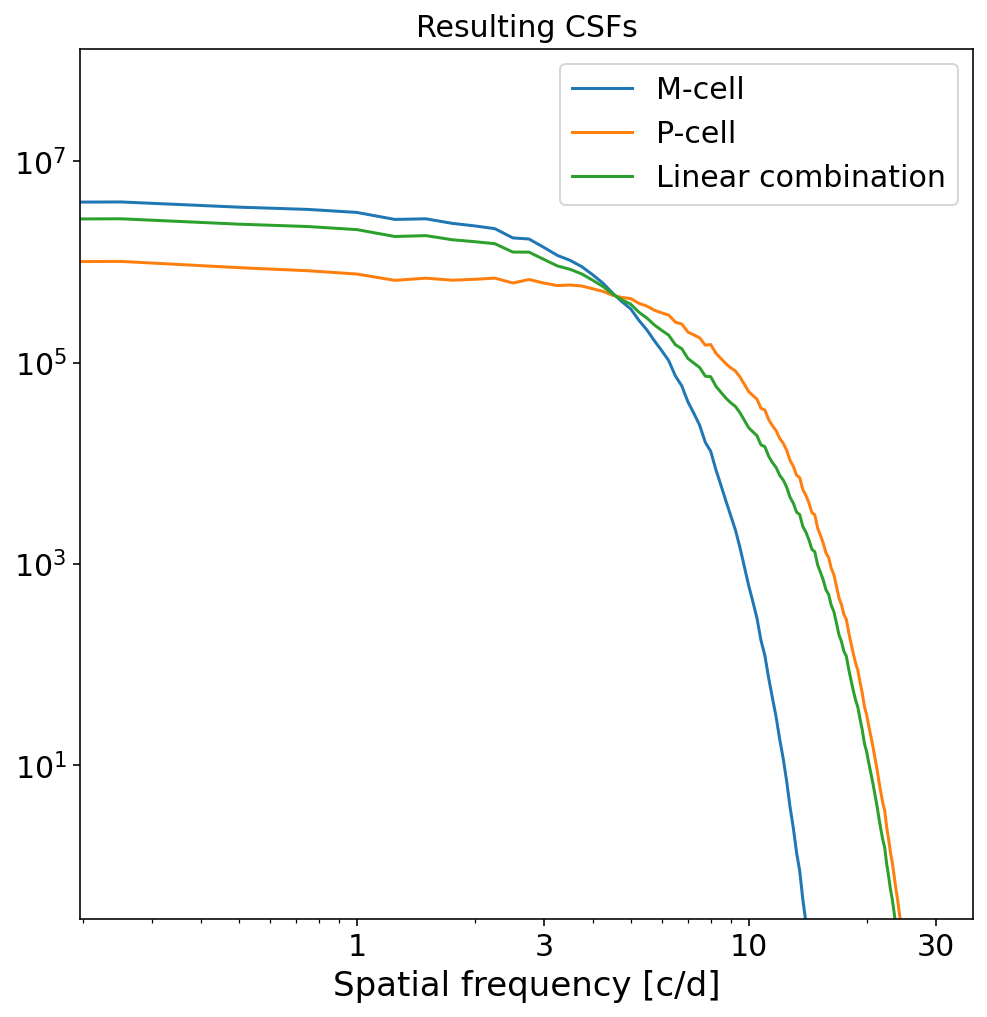

In [65]:
# linear combination
A = 1
lambda_const = 0.57
linear_combination = A * (lambda_const * avg_CR_M + (1 - lambda_const) * avg_CR_P)

# plotting
fig = plt.figure(figsize=(8,8))
plt.title('Resulting CSFs')
ax = fig.gca()

ax.plot(radmean_freq, avg_CR_M, color='C0', label='M-cell')
ax.plot(radmean_freq, avg_CR_P, color='C1', label='P-cell')
ax.plot(radmean_freq, linear_combination, color='C2', label='Linear combination')

ax.set_xlabel('Spatial frequency [c/d]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_ticks([1,3,10,30])
ax.set_ylim(0.3, None) # the graphs from the paper are cut off at 0.3, I think

plt.legend()

plt.show()